In [1]:
import os
import cv2
import glob
import pylab
import keras
import random
import warnings
import shutil
import numpy as np
import splitfolders
import pandas as pd
import seaborn as sns
from PIL import Image
import pydicom as dicom
import tensorflow as tf
%matplotlib inline
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.preprocessing import image
from matplotlib.patches import Rectangle
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam,SGD,RMSprop
from keras.models import Sequential,load_model,Model
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Layer,Input,InputSpec

from keras import backend as K
from keras.utils.layer_utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
#from keras.objectives import categorical_crossentropy
from keras.utils import generic_utils
from keras import initializers, regularizers

In [3]:
#!pip install -U scikit-learn

### LABEL DATA

In [4]:
print("==================================")
label_data=pd.read_csv('stage_2_train_labels.csv')
class_info=pd.read_csv('stage_2_detailed_class_info.csv')
print("Total records in label_data : ",len(label_data))
print("label_data Target value counts : ")
print(label_data['Target'].value_counts())
print("==================================")
print("Total records in class_info : ",len(class_info))
print("class_info class value counts : ")
print(class_info['class'].value_counts())
print("==================================")

Total records in label_data :  30227
label_data Target value counts : 
0    20672
1     9555
Name: Target, dtype: int64
Total records in class_info :  30227
class_info class value counts : 
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


We have equal number of data rows in label_data & class_info ie 30277 
#### Above value counts show that we have: 
non-pneumonia cases i.e "0" : 20672 in the data label

pneumonia cases i.e "1" : 9555 in the data label

In [5]:
# merging the data from class info and labels using the patientid
df_data = pd.merge(left = class_info, right = label_data, how = 'left', on = 'patientId')

In [6]:
#checking how duplicates exists in the data
print(sum(df_data.duplicated()))

7402


#### After merging the data we found out 7402  records are duplicate and hence they can be removed

In [7]:
df_data.drop_duplicates(inplace= True)

In [8]:
df_data.shape

(30227, 7)

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [10]:
df_data.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    NaN    NaN     NaN       0  
1    NaN    NaN     NaN       0  
2    NaN    NaN     NaN       0  
3    NaN    NaN     NaN       0  
4  152.0  213.0   379.0       1

#### Writing a function that can tell us about missing data in the dataframe of labels

In [11]:
# Check for missing data
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data

In [12]:
#for labels
check_for_missing_data(label_data)

Total   Percent
x          20672  0.683892
y          20672  0.683892
width      20672  0.683892
height     20672  0.683892
patientId      0  0.000000
Target         0  0.000000

In [13]:
check_for_missing_data(class_info)

Total  Percent
patientId      0      0.0
class          0      0.0

#### There are no missing value(s) found in the class_info table and all the target values are filled therefore there is no empty value, cells that have Nan or empty cell are having no phenumonia so we should replace those value with 0

In [14]:
label_data.fillna(0, inplace=True)

In [15]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [16]:
label_data[label_data["Target"]==1].describe().T

count        mean         std   min    25%    50%    75%    max
x       9555.0  394.047724  204.574172   2.0  207.0  324.0  594.0  835.0
y       9555.0  366.839560  148.940488   2.0  249.0  365.0  478.5  881.0
width   9555.0  218.471376   59.289475  40.0  177.0  217.0  259.0  528.0
height  9555.0  329.269702  157.750755  45.0  203.0  298.0  438.0  942.0
Target  9555.0    1.000000    0.000000   1.0    1.0    1.0    1.0    1.0

#### from above we can get an idea of mean width and mean height of the phenumoniatic image areas

In [17]:
print(label_data["Target"].value_counts())
np.unique(label_data["Target"])

0    20672
1     9555
Name: Target, dtype: int64


array([0, 1], dtype=int64)

#### Pie chart to show the % of class label data 

<AxesSubplot: ylabel='class'>

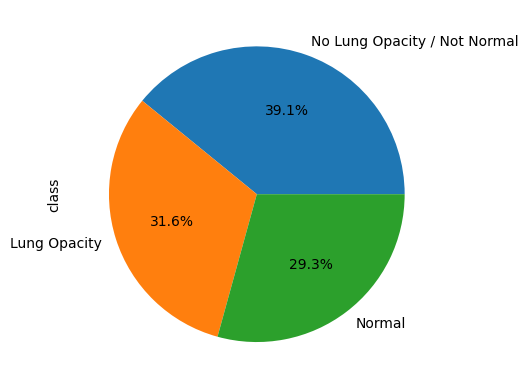

In [18]:
#sns.countplot(label_data["Target"].value_counts())
df_data["class"].value_counts().plot(kind='pie',autopct='%1.1f%%')

#### Pie chart to show the % of Target label data 

<AxesSubplot: ylabel='Target'>

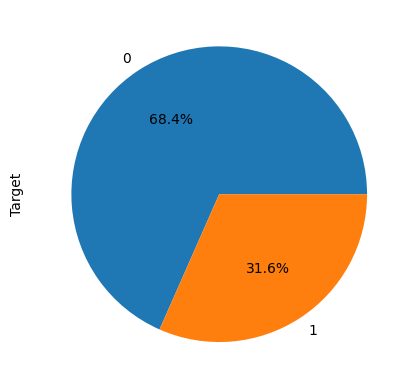

In [19]:
#sns.countplot(label_data["Target"].value_counts())
df_data["Target"].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [20]:
#No Lung Opacity / Not Normal has been classified as Target 0
df_data[df_data["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

patientId                         class   x   y  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal NaN NaN   

   width  height  Target  
0    NaN     NaN       0

In [21]:
#Normally classified data sample with Target 0
df_data[df_data["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

patientId   class   x   y  width  height  Target
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  Normal NaN NaN    NaN     NaN       0

In [22]:
#Pneumonia case classified with target as 1b
df_data[df_data["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

patientId         class      x      y  width  \
4  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  264.0  152.0  213.0   
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  562.0  152.0  256.0   

   height  Target  
4   379.0       1  
5   453.0       1

### Lung Opacity has been classified as 1 and other classes has been classified as Normal indicated as 0
### The class value 'No Lung Opacity / Not Normal ' is classified as 0 as it could be case of other complication which is not phenumonia

In [23]:
pd.pivot_table(df_data,index=["class"], values=['patientId'], aggfunc='count')

patientId
class                                  
Lung Opacity                       9555
No Lung Opacity / Not Normal      11821
Normal                             8851

<AxesSubplot: ylabel='class'>

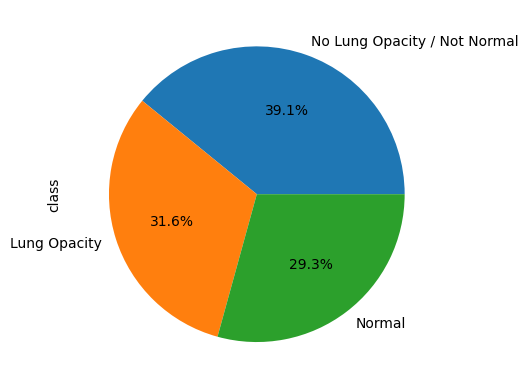

In [24]:
#sns.countplot(label_data["Target"].value_counts())
df_data["class"].value_counts().plot(kind='pie',autopct='%1.1f%%')

### From here we will now be creating a dataframe that will contain all the images and information about those X-Ray images 

In [25]:
#directory information for the pneumonia and non-pneumonia cases 
parent_dir = 'D:/MyData/OneDrive/Study Materials/ML/Great Learning/Olympus/11 Capstone Project/1 Pneumonia Detection/data/'
stage_2_train_img_folder = "stage_2_train_images/"
stage_2_test_img_folder = "stage_2_test_images/"
saved_model_folder_path = 'models_bkp/'
test_image_item = '000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [26]:
# Creating a dataframe with the available columns
column_list = ["patientId", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
train_file_meta_Data = pd.DataFrame(columns=column_list)
test_file_meta_Data = pd.DataFrame(columns=column_list)

In [27]:
print(f"Test image file name : \"{test_image_item}\"")
#displaying the metadata information that comes in a image file 
image_path = os.path.join(parent_dir,stage_2_train_img_folder,test_image_item) 
file = dicom.read_file(image_path)
file

Test image file name : "000db696-cf54-4385-b10b-6b16fbb3f985.dcm"


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

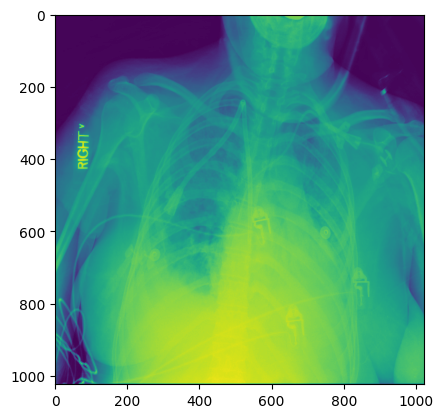

In [28]:
# VIEWING XRAY IMAGE
ds = dicom.dcmread(image_path)
plt.imshow(ds.pixel_array)

In [29]:
#collecting dcm xray filenames in collection
train_images_dir = os.path.join(parent_dir,stage_2_train_img_folder)
test_images_dir = os.path.join(parent_dir,stage_2_test_img_folder)
train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
print('5 Training images', train_images[:5])
print("=================================================================")
print('5 Test images', test_images[:5])

5 Training images ['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '000924cf-0f8d-42bd-9158-1af53881a557.dcm', '000db696-cf54-4385-b10b-6b16fbb3f985.dcm', '000fe35a-2649-43d4-b027-e67796d412e0.dcm', '001031d9-f904-4a23-b3e5-2c088acd19c6.dcm']
5 Test images ['0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm', '0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm', '000686d7-f4fc-448d-97a0-44fa9c5d3aa6.dcm', '000e3a7d-c0ca-4349-bb26-5af2d8993c3d.dcm', '00100a24-854d-423d-a092-edcf6179e061.dcm']


In [30]:
#this finction will add the metadata information to the dataframe and the we can analyze the information
def add_meta_data_to_df(df, loc, from_list):
    data = []
    for filename in from_list:
            imagePath = loc+filename
            data_row_img_data = dicom.read_file(imagePath)
            values = []
            values.append(data_row_img_data.PatientID)
            values.append(data_row_img_data.PatientSex)
            values.append(data_row_img_data.PatientAge)
            values.append(data_row_img_data.ViewPosition)
            values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
            zipped_val = dict(zip(column_list, values))
            df = df.append(zipped_val, True)
    return df

In [39]:
%%time
#loading image files from the train image folder location and collecting metadata patient age,sex,image size etc from there
train_file_meta_Data = add_meta_data_to_df(train_file_meta_Data, train_images_dir, train_images)
test_file_meta_Data = add_meta_data_to_df(test_file_meta_Data,test_images_dir,test_images)

CPU times: total: 2min 9s
Wall time: 4min 49s


In [40]:
print("train image data metadata information dataframe shape : ", train_file_meta_Data.shape)
print("test image data metadata information dataframe shape : ", test_file_meta_Data.shape)

train image data metadata information dataframe shape :  (26684, 5)
test image data metadata information dataframe shape :  (3000, 5)


In [41]:
train_file_meta_Data.head()

patientId Patient Sex Patient's Age  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6           F            51   
1  000924cf-0f8d-42bd-9158-1af53881a557           F            19   
2  000db696-cf54-4385-b10b-6b16fbb3f985           F            25   
3  000fe35a-2649-43d4-b027-e67796d412e0           M            40   
4  001031d9-f904-4a23-b3e5-2c088acd19c6           M            57   

  View Position Image Size  
0            PA  1024x1024  
1            AP  1024x1024  
2            AP  1024x1024  
3            AP  1024x1024  
4            PA  1024x1024

In [42]:
test_file_meta_Data.head()

patientId Patient Sex Patient's Age  \
0  0000a175-0e68-4ca4-b1af-167204a7e0bc           F            46   
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813           F            22   
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6           M            64   
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d           F            75   
4  00100a24-854d-423d-a092-edcf6179e061           F            66   

  View Position Image Size  
0            PA  1024x1024  
1            PA  1024x1024  
2            PA  1024x1024  
3            PA  1024x1024  
4            AP  1024x1024

In [43]:
train_file_meta_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patientId      26684 non-null  object
 1   Patient Sex    26684 non-null  object
 2   Patient's Age  26684 non-null  object
 3   View Position  26684 non-null  object
 4   Image Size     26684 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


<AxesSubplot: ylabel='View Position'>

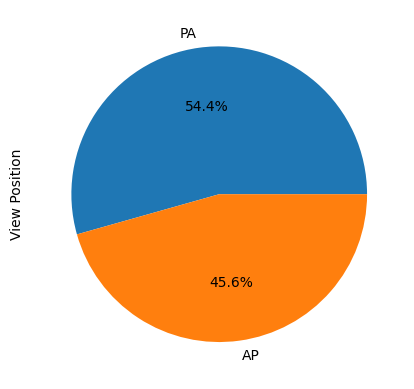

In [44]:
#showing piechart for PA and AP data as piechart
train_file_meta_Data['View Position'].value_counts().plot(kind='pie',autopct='%1.1f%%')

<AxesSubplot: ylabel='View Position'>

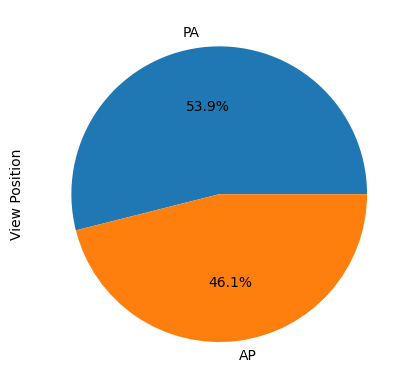

In [45]:
#showing piechart for PA and AP data as piechart
test_file_meta_Data['View Position'].value_counts().plot(kind='pie',autopct='%1.1f%%')

### test file and train file both show somewhat same proportion of view position

<AxesSubplot: title={'center': "Patient's Age"}, xlabel="Patient's Age", ylabel='Density'>

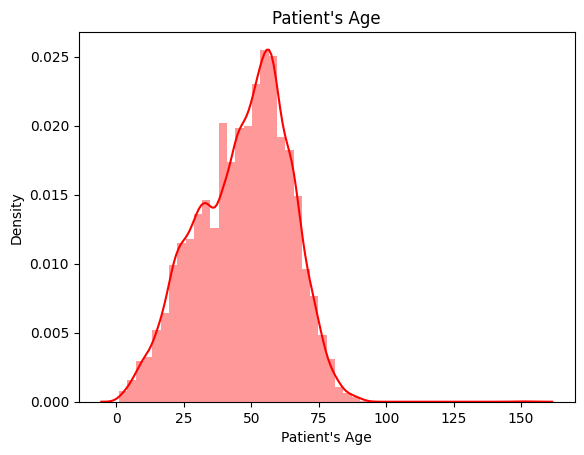

In [46]:
#Printing chart for patient's age
plt.title('Patient\'s Age')
sns.distplot(train_file_meta_Data["Patient's Age"],color='red')

<AxesSubplot: title={'center': "Patient's Age"}, xlabel="Patient's Age", ylabel='Density'>

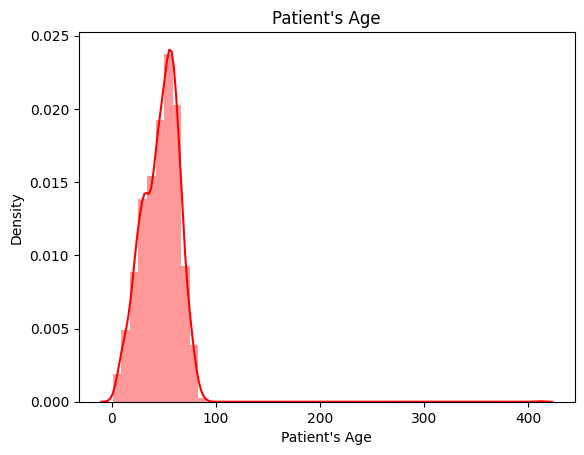

In [47]:
#Printing chart for patient's age
plt.title('Patient\'s Age')
sns.distplot(test_file_meta_Data["Patient's Age"],color='red')

In [48]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 26684
Number of test images: 3000


In [49]:
#method to show image with respective bounding box
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"{train_images_dir}/{patientImage}"
        
        drw_img_data = dicom.read_file(imagePath)
        drow_img = dicom.dcmread(imagePath)
        
        patid = data_row['patientId']
        trgt = data_row['Target']
        modality = drw_img_data.Modality
        age = drw_img_data.PatientAge
        sex = drw_img_data.PatientSex
        chrt_title = f'ID: {patid}\nModality: {modality} Age: {age} Sex: {sex} Target: {trgt}'
        
        ax[i//3, i%3].imshow(drow_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(chrt_title)
        
        rows = df_data[df_data['patientId']==patid]
        box_data = list(rows.T.to_dict().values())
        
        for j, row in enumerate(box_data):
             ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                         width=row['width'],height=row['height'], fc='none', lw=3,
                         color="red",alpha = 0.3))   
    plt.show()

### Chest X-ray images of Normal cases

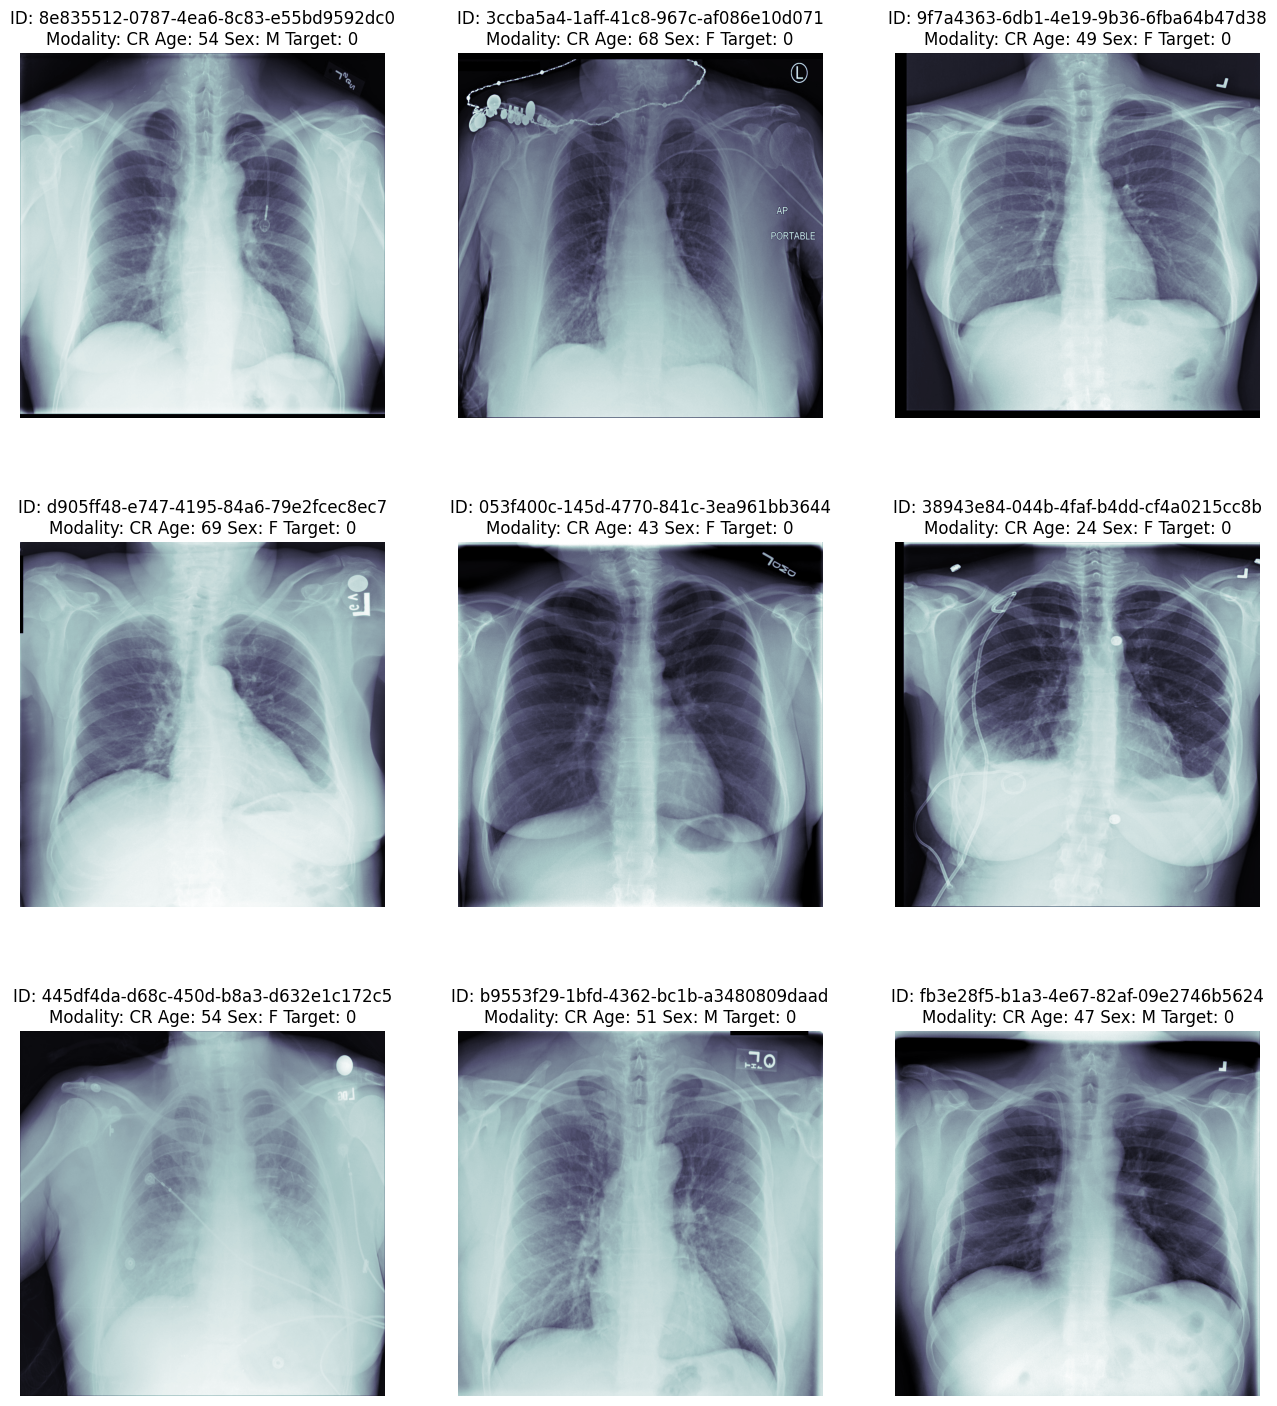

In [50]:
show_dicom_images_with_boxes(df_data[df_data['Target']==0].sample(9))

### Chest X-ray images of Pneumonia cases

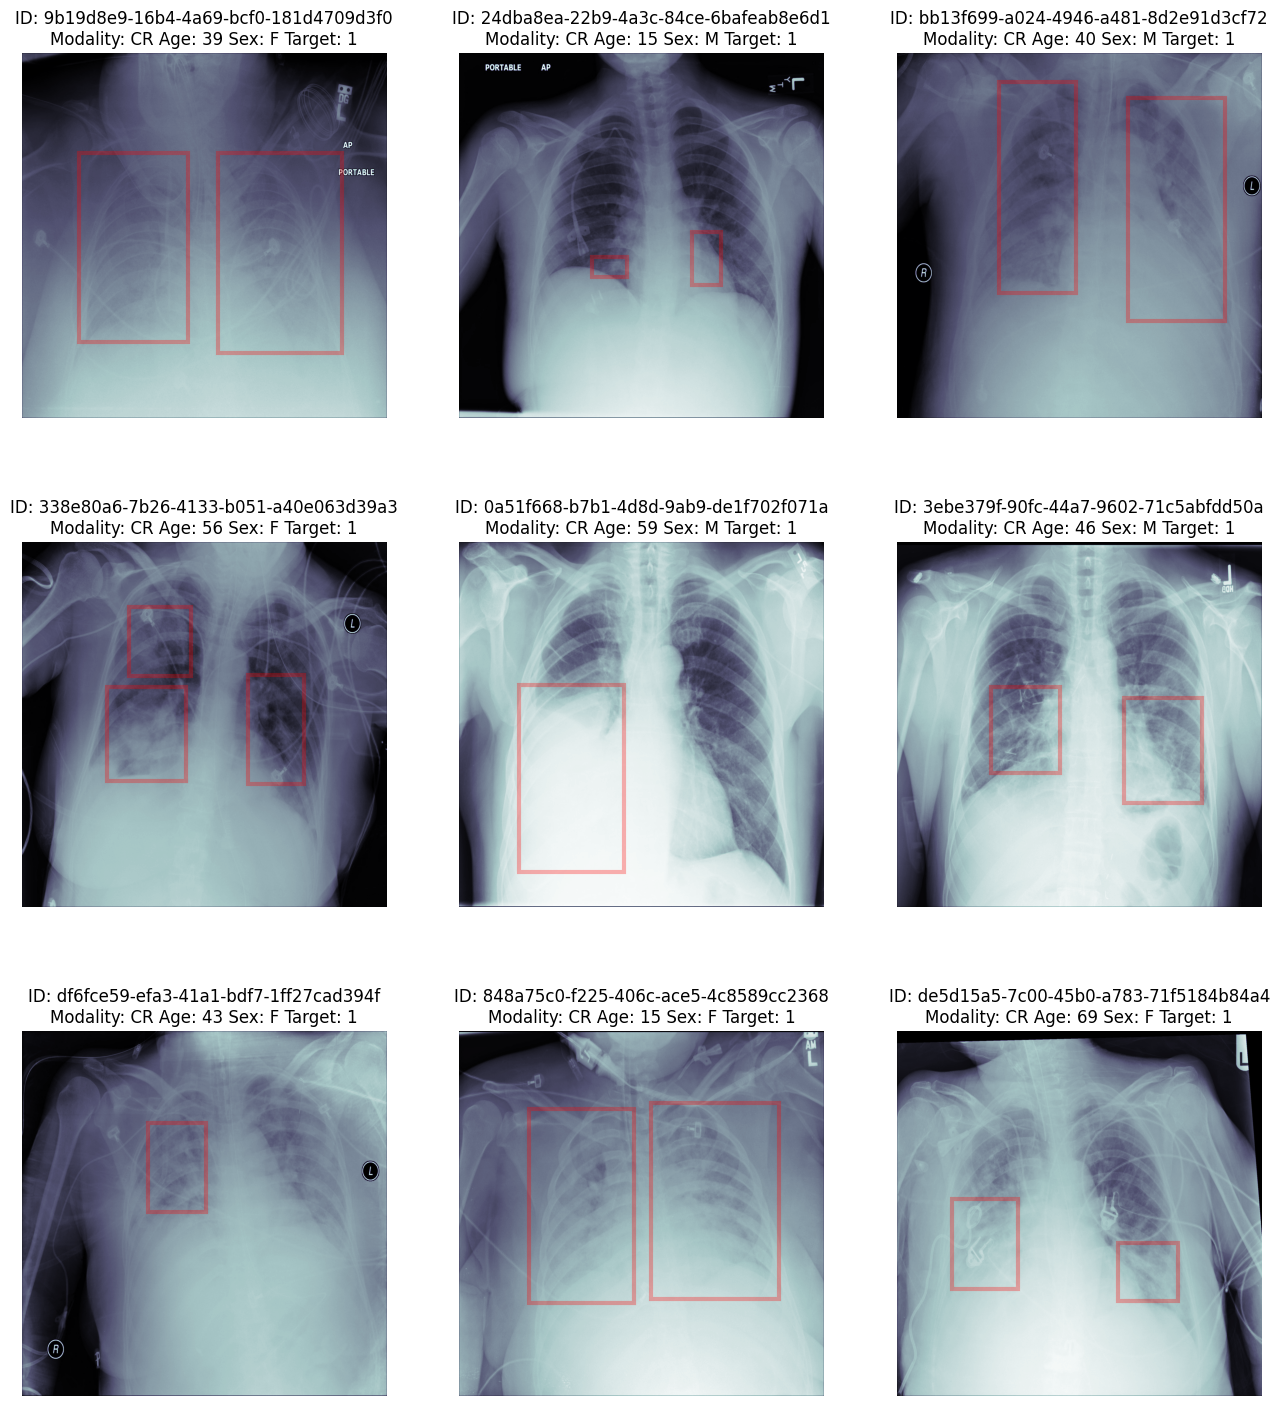

In [51]:
show_dicom_images_with_boxes(df_data[df_data['Target']==1].sample(9))

### DCM FILE TO NUMPY CONVERSION 

### first creating train folder and creating 2 folders for Normal and Pneumonia cases

In [123]:
%%time
img_working_dirname = 'C:/Users/acer/ML_Projects/working_images'
img_working_dcm_to_jpg_train = img_working_dirname + '/pne_jpg_data/train/'
img_working_dcm_to_jpg_test = img_working_dirname + '/pne_jpg_data/test/'
img_working_split_ = img_working_dirname + '/d_/'
img_working_anno_dirname = img_working_dirname + '/annotation/'
img_working_csv_dirname = img_working_dirname + '/csv_files/'
#######FOR YOLO WORK############
img_working_yolo_dirname = img_working_dirname + '/yolo/'
img_working_yolo_images_dirname = img_working_dirname + '/yolo/images/'
img_working_yolo_labels_dirname = img_working_dirname + '/yolo/labels/'
img_working_yolo_images_train_dirname = img_working_dirname + '/yolo/images/train/'
img_working_yolo_labels_train_dirname = img_working_dirname + '/yolo/labels/train/'
img_working_yolo_images_test_dirname = img_working_dirname + '/yolo/images/test/'
img_working_yolo_labels_test_dirname = img_working_dirname + '/yolo/labels/test/'
img_working_yolo_images_val_dirname = img_working_dirname + '/yolo/images/val/'
img_working_yolo_labels_val_dirname = img_working_dirname + '/yolo/labels/val/'
#img_working_yolo_test_dirname = img_working_dirname + '/yolo/test/'

if not os.path.exists(img_working_dirname+"models_bkp"):
    os.mkdir(img_working_dirname+"models_bkp")  #empty test image folder

def create_image_directory_structure(rm_existing=False):
    if rm_existing:
        if os.path.exists("working_images"):
            shutil.rmtree("working_images") 
    if not os.path.exists("working_images"):
        os.mkdir("working_images")  #empty images folder 
    if not os.path.exists("working_images/pne_jpg_data"):
        os.mkdir("working_images/pne_jpg_data")  #empty images folder 
    if not os.path.exists("working_images/pne_jpg_data/train"):
        os.mkdir("working_images/pne_jpg_data/train")  #empty images folder 
    if not os.path.exists("working_images/pne_jpg_data/train/normal"):
        os.mkdir("working_images/pne_jpg_data/train/normal")  #empty images folder 
    if not os.path.exists("working_images/pne_jpg_data/train/pneumonia"):
        os.mkdir("working_images/pne_jpg_data/train/pneumonia")  #empty images folder 
    if not os.path.exists("working_images/pne_jpg_data/test"):
        os.mkdir("working_images/pne_jpg_data/test")  #empty images folder 
    
    ############# YOLO start
    #Yolo train Labels
    if not os.path.exists(img_working_yolo_dirname):
        os.mkdir(img_working_yolo_dirname)  #empty YOLO parent folder
    #Yolo images and lables parent    
    if not os.path.exists(img_working_yolo_images_dirname):
        os.mkdir(img_working_yolo_images_dirname)  #empty Yolo images folder
    if not os.path.exists(img_working_yolo_labels_dirname):
        os.mkdir(img_working_yolo_labels_dirname)  #empty Yolo Labels folder
        
    #Yolo train Labels and images
    if not os.path.exists(img_working_yolo_labels_train_dirname):
        os.mkdir(img_working_yolo_labels_train_dirname)  #empty labels train folder 
    if not os.path.exists(img_working_yolo_images_train_dirname):
        os.mkdir(img_working_yolo_images_train_dirname)  #empty yolo images Train folder 
    #Yolo test Labels and images 
    if not os.path.exists(img_working_yolo_images_test_dirname):
        os.mkdir(img_working_yolo_images_test_dirname)  #empty yolo images test folder 
    if not os.path.exists(img_working_yolo_labels_test_dirname):
        os.mkdir(img_working_yolo_labels_test_dirname)  #empty labels test folder 
    #Yolo val Labels and images 
    if not os.path.exists(img_working_yolo_images_val_dirname):
        os.mkdir(img_working_yolo_images_val_dirname)  #empty yolo images val folder 
    if not os.path.exists(img_working_yolo_labels_val_dirname):
        os.mkdir(img_working_yolo_labels_val_dirname)  #empty labels val folder 
        
    ############# YOLO END
    if not os.path.exists("working_images/annotation"):
        os.mkdir("working_images/annotation")  #empty images folder 

    if not os.path.exists("working_images/csv_files"):
        os.mkdir("working_images/csv_files")  #empty images folder 

    if not os.path.exists("working_images/d_"):#train image folder
        os.mkdir("working_images/d_") 
    if not os.path.exists("working_images/d_/train"):#train image folder
        os.mkdir("working_images/d_/train") 
    if not os.path.exists("working_images/d_/val"):#train image folder
        os.mkdir("working_images/d_/val")  
    if not os.path.exists("working_images/d_/test"):#train image folder
        os.mkdir("working_images/d_/test")  
    if not os.path.exists("working_images/d_/train/normal"):#image folder for normal cases  
        os.mkdir("working_images/d_/train/normal")
    if not os.path.exists("working_images/d_/train/pneumonia"):#image folder for pneumonia cases  
        os.mkdir("working_images/d_/train/pneumonia")  
    if not os.path.exists("working_images/d_/val/normal"):#image folder for normal cases  
        os.mkdir("working_images/d_/val/normal")
    if not os.path.exists("working_images/d_/val/pneumonia"):#image folder for pneumonia cases  
        os.mkdir("working_images/d_/val/pneumonia")  
    if not os.path.exists("working_images/d_/test/normal"):
        os.mkdir("working_images/d_/test/normal")  #empty test image folder
    if not os.path.exists("working_images/d_/test/pneumonia"):
        os.mkdir("working_images/d_/test/pneumonia")  #empty test image folder


CPU times: total: 0 ns
Wall time: 2 ms


In [53]:
#creating folder structure
create_image_directory_structure()

In [54]:
print(df_data.shape)
print(train_file_meta_Data.shape)

(30227, 7)
(26684, 5)


In [55]:
#file_meta_Data.rename(columns={"patientid":"patientId"},inplace=True)
df_data = df_data.join(train_file_meta_Data.set_index('patientId'),on="patientId",how="inner")
#df_data.patientId

In [56]:
print(df_data.shape)
df_data.head()
#file_meta_Data.head()

(30227, 11)


patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target Patient Sex Patient's Age View Position  \
0    NaN    NaN     NaN       0           F            51            PA   
1    NaN    NaN     NaN       0           F            48            PA   
2    NaN    NaN     NaN       0           M            19            AP   
3    NaN    NaN     NaN       0           M            28            PA   
4  152.0  213.0   379.0       1           F            32            AP   

  Image Size  
0  1024x1024  
1  1024x1024  
2  1024x1024  
3  1024x1024  
4  1024x1024

In [57]:
#re-working on the data selection as now we want to consider both type of view positions
df_tmp_normal = df_data[df_data["Target"]==0]
df_tmp_pneumo = df_data[df_data["Target"]==1]
df_tmp_normal.reset_index(inplace=True)
df_tmp_pneumo.reset_index(inplace=True)

#sampling 5000 rows randomly from the collection from normal & penumonia infected case data
df_temp_normal_AP = df_tmp_normal[df_tmp_normal["View Position"] == "AP"]
df_temp_normal_AP.reset_index(inplace=True)
df_temp_normal_PA = df_tmp_normal[df_tmp_normal["View Position"] == "PA"]
df_temp_normal_PA.reset_index(inplace=True)

df_temp_pneumonia_AP = df_tmp_pneumo[df_tmp_pneumo["View Position"] == "AP"]
df_temp_pneumonia_AP.reset_index(inplace=True)
df_temp_pneumonia_PA = df_tmp_pneumo[df_tmp_pneumo["View Position"] == "PA"]
df_temp_pneumonia_PA.reset_index(inplace=True)
#print("Shape of all PA with normal cases",df_tmp_normal.shape)
#print("Shape of all PA with pneumonia cases",df_tmp_pneumo.shape)
print("Shape of all normal cases",df_tmp_normal.shape)
print("Shape of all pneumonia cases",df_tmp_pneumo.shape)

#for patid in file_meta_Data[file_meta_Data["View Position"]=="PA"]

Shape of all normal cases (20672, 12)
Shape of all pneumonia cases (9555, 12)


#### we have 1767 pneumonia cases and 13163 non penumonia cases (normal). We want to create a sample where we can have equal number of normal and pneumonia cases i.e. we may consider 1500 cases of pneumonia and 1500 case of normal. and because we have multiple entries for pneumonia cases for the same patient id beause of multiple annotation so the size may be more than 3000 of the final dataframe and  for this reason we will select 1500 patient ids from normal and  pneumonia cases from "file_meta_Data" dataframe

#### after re-considering all the cases whether the XRays are of PA or the AP type view position we found around 20672 case we have as normal cases and 9555 cases as pneumonia

In [58]:
df_tmp_pneumo["View Position"].value_counts()

AP    7788
PA    1767
Name: View Position, dtype: int64

In [59]:
df_tmp_normal["View Position"].value_counts()

PA    13163
AP     7509
Name: View Position, dtype: int64

### After filtering Pneumonia cases and Normal cases we have 7788 AP view position data and 1767 PA cases we will create sample in such a way that when we model our data it will have equal number of PA/AP view position data in pneumonia and other one will be Normal cases.
### we also observe that our normal cases also have "PA" view position as 13163 count and AP we have 7509 coumt. so our sample data from these normal case must have equal number of PA and AP view position data in our train same so that our model predict correctly.
### If we choose a sample collection of 5000 image data than we may consider 2500 normal case images with 1250 patients with Xrays as PA and AP view position and 2500 pneumonia cases with 1250 PA view position and 1250 AP view Position

In [60]:
#Pneumonia cases only 
#df_temp_AP.join(,how="inner",on="patientId")
ii = 0
com_patid_ap = []
com_patid_ap_alrdy_exist = []
com_patid_pa = []
com_patid_pa_alrdy_exist = []
#common_patid_ap = []
for patid in list(df_temp_pneumonia_AP['patientId']):
    if patid not in com_patid_ap:
        com_patid_ap.append(patid)
    else:
        com_patid_ap_alrdy_exist.append(patid)
        
for patid in list(df_temp_pneumonia_PA['patientId']):
    if patid not in com_patid_pa:
        com_patid_pa.append(patid)
    else:
        com_patid_pa_alrdy_exist.append(patid)
        

print("Pneumonia \"PA\" View Position shape : ", df_temp_pneumonia_PA.shape," ~~~ distinct patientid count : ", len(com_patid_pa),"~~~ paientid found again : ",len(com_patid_ap_alrdy_exist))
print("Pneumonia \"AP\" View Position shape : ", df_temp_pneumonia_AP.shape," ~~~ distinct patientid count : ", len(com_patid_ap),"~~~ paientid found again : ",len(com_patid_pa_alrdy_exist))


Pneumonia "PA" View Position shape :  (1767, 13)  ~~~ distinct patientid count :  1348 ~~~ paientid found again :  3124
Pneumonia "AP" View Position shape :  (7788, 13)  ~~~ distinct patientid count :  4664 ~~~ paientid found again :  419


In [61]:
df_tmp_pneumo[df_tmp_pneumo["patientId"] == '00704310-78a8-4b38-8475-49f4573b2dbb']

index                             patientId         class      x      y  \
2     10  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  323.0  577.0   
3     11  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  695.0  575.0   

   width  height  Target Patient Sex Patient's Age View Position Image Size  
2  160.0   104.0       1           M            75            PA  1024x1024  
3  162.0   137.0       1           M            75            PA  1024x1024

In [62]:
#norma cases only 
#df_temp_AP.join(,how="inner",on="patientId")
ii = 0
com_patid_normal_ap = []
com_patid_normal_ap_alrdy_exist = []
com_patid_normal_pa = []
com_patid_normal_pa_alrdy_exist = []
#common_patid_ap = []
for patid in list(df_temp_normal_AP['patientId']):
    if patid not in com_patid_normal_ap:
        com_patid_normal_ap.append(patid)
    else:
        com_patid_normal_ap_alrdy_exist.append(patid)
        
for patid in list(df_temp_normal_PA['patientId']):
    if patid not in com_patid_normal_pa:
        com_patid_normal_pa.append(patid)
    else:
        com_patid_normal_pa_alrdy_exist.append(patid)
        

print("Normal \"PA\" View Position shape : ", df_temp_normal_PA.shape," ~~~ distinct patientid count : ", len(com_patid_normal_pa),"~~~ paientid found again : ",len(com_patid_normal_ap_alrdy_exist))
print("Normal \"AP\" View Position shape : ", df_temp_normal_AP.shape," ~~~ distinct patientid count : ", len(com_patid_normal_ap),"~~~ paientid found again : ",len(com_patid_normal_pa_alrdy_exist))


Normal "PA" View Position shape :  (13163, 13)  ~~~ distinct patientid count :  13163 ~~~ paientid found again :  0
Normal "AP" View Position shape :  (7509, 13)  ~~~ distinct patientid count :  7509 ~~~ paientid found again :  0


### We found 1348 patients are pneumonia cases with XRay view position was "PA", 4664 patient counts are for "AP" View position so we will pick 1250 patientid from each PA and AP cases.
### But in normal cases we 13163 patientid with PA view position and 7509 with AP view position. so in normal cases also we will pick 1250 normal cases of "PA" and 1250  of "AP" view position

In [63]:
%%time

#random pick from normal cases with AP position
ran_picked_indexes = random.sample([a for a in range(0,len(df_temp_normal_AP))], k=1400)
ran_picked_normal_ap_patid = df_temp_normal_AP.loc[ran_picked_indexes,["patientId"]].values
#random pick from normal cases with PA position
ran_picked_indexes = random.sample([a for a in range(0,len(df_temp_normal_PA))], k=1400)
ran_picked_normal_pa_patid = df_temp_normal_PA.loc[ran_picked_indexes,["patientId"]].values
#random pick from pneumonia cases with AP position
ran_picked_indexes = random.sample([a for a in range(0,len(df_temp_pneumonia_AP))], k=1400)
ran_picked_pneumo_ap_patid = df_temp_pneumonia_AP.loc[ran_picked_indexes,["patientId"]].values
#random pick from pneumonia cases with PA position
ran_picked_indexes = random.sample([a for a in range(0,len(df_temp_pneumonia_PA))], k=1348)
ran_picked_pneumo_pa_patid = df_temp_pneumonia_PA.loc[ran_picked_indexes,["patientId"]].values


print("Normal AP shape : ",ran_picked_normal_ap_patid.shape)
print("Normal PA shape : ",ran_picked_normal_pa_patid.shape)
print("Pneumonia AP shape : ",ran_picked_pneumo_ap_patid.shape)
print("Pneumonia PA shape : ",ran_picked_pneumo_pa_patid.shape)

# will now transfer dcm files from parent location to the respective train folders for normal and pneumonia cases
df_data_ap_trg0 = df_temp_normal_AP.loc[df_temp_normal_AP.apply(lambda x: x.patientId in ran_picked_normal_ap_patid, axis=1)]
df_data_pa_trg0 = df_temp_normal_PA.loc[df_temp_normal_PA.apply(lambda x: x.patientId in ran_picked_normal_pa_patid, axis=1)]
df_data_pa_trg1 = df_temp_pneumonia_PA.loc[df_temp_pneumonia_PA.apply(lambda x: x.patientId in ran_picked_pneumo_pa_patid, axis=1)]
df_data_ap_trg1 = df_temp_pneumonia_AP.loc[df_temp_pneumonia_AP.apply(lambda x: x.patientId in ran_picked_pneumo_ap_patid, axis=1)]
print("final sample AP normal cases: ", df_data_ap_trg0.shape)
print("final sample PA normal cases: ", df_data_pa_trg0.shape)
print("final sample PA penumo cases: ", df_data_pa_trg1.shape)
print("final sample AP penumo cases: ", df_data_ap_trg1.shape)
df_combined = [df_data_ap_trg0,df_data_pa_trg0,df_data_pa_trg1,df_data_ap_trg1]
df_data_final = pd.concat(df_combined)
print("final sample combined: ", df_data_final.shape)
#shuffling the dataframe rows
df_data_final = df_data_final.sample(frac = 1)
df_data_final.set_index("index",inplace=True)
df_data_final.reset_index(inplace=True,drop=True)
df_data_final.head()

Normal AP shape :  (1400, 1)
Normal PA shape :  (1400, 1)
Pneumonia AP shape :  (1400, 1)
Pneumonia PA shape :  (1348, 1)
final sample AP normal cases:  (1400, 13)
final sample PA normal cases:  (1400, 13)
final sample PA penumo cases:  (1519, 13)
final sample AP penumo cases:  (2375, 13)
final sample combined:  (6694, 13)
CPU times: total: 828 ms
Wall time: 809 ms


level_0                             patientId  \
0     3184  48a44f52-7fb3-4384-a76b-f6170b03a357   
1     2509  49b95513-daab-49bb-bc6e-c5254ab1bc07   
2    12362  a985f470-12d9-48b0-bb1a-5bdffc657c47   
3     7670  75ac9b0b-6f99-49f1-865c-3ccf54144b1a   
4     1239  33c66fa9-6a08-4d0d-b309-88ce91a217c9   

                          class      x      y  width  height  Target  \
0                        Normal    NaN    NaN    NaN     NaN       0   
1                  Lung Opacity  599.0  202.0  216.0   537.0       1   
2  No Lung Opacity / Not Normal    NaN    NaN    NaN     NaN       0   
3  No Lung Opacity / Not Normal    NaN    NaN    NaN     NaN       0   
4                  Lung Opacity  193.0  468.0  209.0   120.0       1   

  Patient Sex Patient's Age View Position Image Size  
0           F            50            AP  1024x1024  
1           F            67            AP  1024x1024  
2           F            58            PA  1024x1024  
3           M            65            AP  1024x1024  
4           F            53            PA  1024x1024

In [64]:
df_data_final["patientId"].nunique()

5219

### Checking the data distribution in our sample data
#### Patient Gender 

<AxesSubplot: ylabel='Patient Sex'>

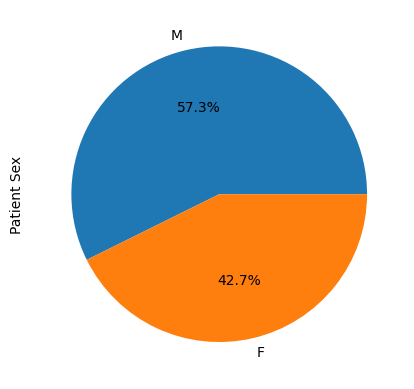

In [65]:
df_data_final["Patient Sex"].value_counts().plot(kind='pie',autopct='%1.1f%%')

#### Patient's Age distribution

<AxesSubplot: title={'center': "Patient's Age"}, xlabel="Patient's Age", ylabel='Density'>

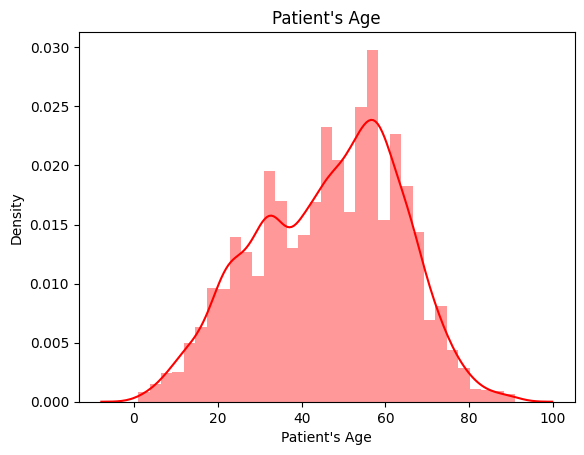

In [66]:
#Printing chart for patient's age
plt.title('Patient\'s Age')
sns.distplot(df_data_final["Patient's Age"],color='red')

In [67]:
print(train_images_dir)
print(test_images_dir)

D:/MyData/OneDrive/Study Materials/ML/Great Learning/Olympus/11 Capstone Project/1 Pneumonia Detection/data/stage_2_train_images/
D:/MyData/OneDrive/Study Materials/ML/Great Learning/Olympus/11 Capstone Project/1 Pneumonia Detection/data/stage_2_test_images/


In [68]:
def get_sharpened_and_resized_array_of_image(img_arr_):
    #https://stackoverflow.com/a/54465855/1225413
    #https://stackoverflow.com/a/6917185/1225413
    """
    Since the given dataset images are grayscale, we can improve the performance by sharpening. Also, we can reduce the 
    image size from 1024 *1024 to 256*256, cause their is rarely any improvement shown in model performance.
    """
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])
    #resized array
    resized_img_ = cv2.resize(img_arr_, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)

    #appyling kernel to sharpen the image
    sharpened_ = cv2.filter2D(resized_img_, -1, kernel)
    sharpened_ =  (255.0 / sharpened_.max() * (sharpened_ - sharpened_.min())).astype(np.uint8)
    return sharpened_

In [69]:
df_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   level_0        6694 non-null   int64  
 1   patientId      6694 non-null   object 
 2   class          6694 non-null   object 
 3   x              3894 non-null   float64
 4   y              3894 non-null   float64
 5   width          3894 non-null   float64
 6   height         3894 non-null   float64
 7   Target         6694 non-null   int64  
 8   Patient Sex    6694 non-null   object 
 9   Patient's Age  6694 non-null   object 
 10  View Position  6694 non-null   object 
 11  Image Size     6694 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 627.7+ KB


In [70]:
#creating folder structure
create_image_directory_structure(True)

In [71]:
pneumonia_case_images = []
normal_case_images = []
#for now we will be using only 5000+ images for normal and pneumonia cases randomly  
def transfer_dcm_to_jpg_wd_folder(image_type):
    images_path = os.listdir(train_images_dir)
    non_found_images = []

    ii = 0
    
    for patid in list(df_data_final["patientId"].unique()):
        
        xrdcm_fname = patid + '.dcm' #dcm filename
        xrjpg_fname = patid + '.' + image_type 
        dcm_img_path = os.path.join(train_images_dir, xrdcm_fname)
        copyto_loc = ''
        df_data_final.loc[df_data_final["patientId"]==patid]
        trgt=0
        for i,row in df_data_final[df_data_final["patientId"]==patid].iterrows():
              trgt = row["Target"]     
        if os.path.exists(dcm_img_path):     
            if trgt == 1:
                copyto_loc = os.path.join(img_working_dcm_to_jpg_train+"/pneumonia/",xrjpg_fname)
                pneumonia_case_images.append(xrjpg_fname)
            else:
                copyto_loc = os.path.join(img_working_dcm_to_jpg_train+"/normal/",xrjpg_fname)  
                normal_case_images.append(xrjpg_fname)

            ds = dicom.dcmread(dcm_img_path)
            arr_img_ = ds.pixel_array
            cv2.imwrite(copyto_loc, arr_img_)
        else:
            non_found_images.append(xrdcm_fname)
        ii += 1
#         if ii > 100:
#             break
    
    print("total converted to png from dcm :",ii)
    print("total normal cases converted to png from dcm :",len(normal_case_images))
    print("total pneumonia cases converted to png from dcm :",len(pneumonia_case_images))
    print("total not found images :",len(non_found_images))
#transfer_dcm_to_jpg_wd_folder('jpg')

In [72]:
%time
#converting and transfering images to train folder
transfer_dcm_to_jpg_wd_folder('jpg')

CPU times: total: 0 ns
Wall time: 0 ns
total converted to png from dcm : 5219
total normal cases converted to png from dcm : 2800
total pneumonia cases converted to png from dcm : 2419
total not found images : 0


In [73]:
def traindata_to_trainvaltest_split():

    val_ratio = 0.20
    test_ratio = 0.20

    for cls in ['normal','pneumonia']:
        # Creating partitions of the data after shuffeling
        src = img_working_dcm_to_jpg_train +"//" + cls  # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_imgfiles, val_imgfiles, test_imgfiles = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])
        
        train_imgfiles = [src + '//' + name for name in train_imgfiles.tolist()]
        val_imgfiles = [src + '//' + name for name in val_imgfiles.tolist()]
        test_imgfiles = [src + '//' + name for name in test_imgfiles.tolist()]
        
        print(f'{cls} Total images: '+ str(len(allFileNames)))
        print(f'{cls} Training    : '+ str(len(train_imgfiles)))
        print(f'{cls} Validation  : '+  str(len(val_imgfiles)))
        print(f'{cls} Testing     : '+ str(len(test_imgfiles)))
        
        for name in train_imgfiles:
            shutil.copy(name, img_working_split_ + '/train//' + cls)

        for name in val_imgfiles:
            shutil.copy(name, img_working_split_ + '/val//' + cls)

        for name in test_imgfiles:
            shutil.copy(name, img_working_split_ + '/test//' + cls)

traindata_to_trainvaltest_split()

normal Total images: 2800
normal Training    : 1680
normal Validation  : 560
normal Testing     : 560
pneumonia Total images: 2419
pneumonia Training    : 1451
pneumonia Validation  : 484
pneumonia Testing     : 484


In [74]:
#for now we will be using only 2000 images for normal cases and 2000 pneumonia cases randomly  
def create_dcm_to_train_folder(image_type):
    images_path = os.listdir(train_images_dir)
    normal_count = 0
    pneumo_count = 0
    non_found_images = []
    
    for n, img_fname in enumerate(images_path):
        img_patid = img_fname.replace('.dcm','')
        img_fname_ = img_fname.replace('.dcm','.' + image_type)
        dcm_image_loc =  train_images_dir
        copy_filepath = ""
        ds = dicom.dcmread(os.path.join(train_images_dir, img_fname))
        
        # Normal PA
        if img_patid in ran_picked_normal_ap_patid:
            if os.path.exists(dcm_image_loc):
                #get the image resized and apply sharpening kernel
                arr_img_ = ds.pixel_array #get_sharpened_and_resized_array_of_image(ds.pixel_array) 
                cv2.imwrite(os.path.join(img_working_dirname+"/train/normal/",img_fname_), arr_img_)
                normal_count = normal_count + 1
            else:
                non_found_images.append("normal_"+dcm_image_loc)
            #print('normal')

        
        if img_patid in ran_picked_normal_pa_patid:
            if os.path.exists(dcm_image_loc):
                #get the image resized and apply sharpening kernel
                arr_img_ = ds.pixel_array # get_sharpened_and_resized_array_of_image(ds.pixel_array)
                cv2.imwrite(os.path.join(img_working_dirname+"/train/normal/",img_fname_), arr_img_)
                #cv2.imwrite(copyto_filepath, arr_img_)
                normal_count = normal_count + 1
            else:
                non_found_images.append("normal_"+dcm_image_loc)
            #print('normal')

        if img_patid in ran_picked_pneumo_ap_patid:
            if os.path.exists(dcm_image_loc):
                #get the image resized and apply sharpening kernel
                arr_img_ = ds.pixel_array #get_sharpened_and_resized_array_of_image(ds.pixel_array)
                cv2.imwrite(os.path.join(img_working_dirname+"/train/pneumonia/",img_fname_), arr_img_)
                #cv2.imwrite(copyto_filepath, arr_img_)
                pneumo_count = pneumo_count + 1
            else:
                non_found_images.append("pneumo_"+dcm_image_loc)
                
        if img_patid in ran_picked_pneumo_pa_patid:
            if os.path.exists(dcm_image_loc):
                #get the image resized and apply sharpening kernel
                arr_img_ = ds.pixel_array #get_sharpened_and_resized_array_of_image(ds.pixel_array)
                cv2.imwrite(os.path.join(img_working_dirname+"/train/pneumonia/",img_fname_), arr_img_)
                #cv2.imwrite(copyto_filepath, arr_img_)
                pneumo_count = pneumo_count + 1
            else:
                non_found_images.append("pneumo_"+dcm_image_loc)
            #print('pneumo')
    #     if ii > 20:
    #         break  
    print("total normal cases converted to png from dcm :",normal_count)
    print("total pneumo cases converted to png from dcm :",pneumo_count)
    print("total notfound images :",len(non_found_images))

In [75]:
test_images_dir

'D:/MyData/OneDrive/Study Materials/ML/Great Learning/Olympus/11 Capstone Project/1 Pneumonia Detection/data/stage_2_test_images/'

In [76]:
#test images to working directory with resized format 
def create_dcm_to_test_folder(image_type):
    ii = 0
    if os.path.exists(img_working_dcm_to_jpg_test) and os.path.exists(test_images_dir):
        images_path = os.listdir(test_images_dir)
        for n, img_fname in enumerate(images_path): 
            img_patid = img_fname.replace('.dcm','')
            img_fname_jpg = img_fname.replace('.dcm','.' + image_type)
            img_path = test_images_dir+"/"+ img_fname
            img_ = dicom.read_file(img_path)
            arr_img_ = img_.pixel_array
            #get the image resized and apply sharpening kernel
            #arrimg_ = #get_sharpened_and_resized_array_of_image(arr_img_)
            cv2.imwrite(os.path.join(img_working_dcm_to_jpg_test,img_fname_jpg), arr_img_)
            #print(os.path.join(img_working_dcm_to_jpg_test,img_fname_jpg))
            ii = ii + 1
#             if ii > 2:
#                 break
        #print(ii, f" dcm files converted and resized({IMG_HEIGHT} X {IMG_WIDTH}) to png at :",copyto_loc_)
        print(ii, f" dcm files converted to png at :",img_working_dcm_to_jpg_test)
    else:
        print("locations not found.")        

In [77]:
%%time
create_dcm_to_test_folder('jpg')

3000  dcm files converted to png at : C:/Users/acer/ML_Projects/working_images/pne_jpg_data/test/
CPU times: total: 43 s
Wall time: 43.2 s


### Creating Data Generators

In [78]:
def get_random_test_image_from_test_folder(_test_image_class,n_count):
    fld_path = img_working_split_ + 'test/' + _test_image_class
    #print(fld_path)
    _image_names_collection = []
    if os.path.exists(fld_path):
        images_path = os.listdir(fld_path)
        ran_picked_image_indices = random.sample([a for a in range(0,len(images_path))], k=n_count)
        for n, img_fname in enumerate(images_path):
            if n in ran_picked_image_indices:
                f = fld_path + "/" + img_fname
                _image_names_collection.append(f)
    else :
        print('no hello')
    return _image_names_collection
        
#print(img_working_dcm_to_jpg_test)
#get_random_test_image_from_test_folder('pneumonia',10)
#get_random_test_image_from_test_folder('normal',10)

In [79]:
#path for the image to see if it predicts correct class
_test_images_normal = get_random_test_image_from_test_folder('normal',6)
_test_images_pneumo = get_random_test_image_from_test_folder('pneumonia',6)

In [80]:
print(img_working_split_)
# Create data generator for training data with data augmentation and normalizing all values by 255
train_image_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   shear_range = 0.05,
                                   zoom_range = 0.3,
                                   brightness_range=(1.2,1.5),
                                   horizontal_flip = True)

train_generator = train_image_datagen.flow_from_directory(img_working_split_+"/train",
                                                 target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size = 16,
                                                 class_mode = 'binary',
                                                 shuffle=True)


val_image_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_image_datagen.flow_from_directory(img_working_split_+"/val",
                                                 target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size = 16,
                                                 class_mode = 'binary',
                                                 shuffle=True)

# # Setting testing data generator's source directory
test_image_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_image_datagen.flow_from_directory(img_working_split_+"/test",
                                            target_size = (IMG_HEIGHT, IMG_WIDTH),
                                            batch_size = 16,
                                            class_mode = 'binary')
############################################## VGG16 ######################################
train_image_datagen_vgg16 = ImageDataGenerator(rescale = 1./255,
                                   #rotation_range=30,
                                   #shear_range = 0.05,
                                   zoom_range = 0.3,
                                   brightness_range=(1.2,1.5),
                                   horizontal_flip = True)


train_generator_vgg16 = train_image_datagen_vgg16.flow_from_directory(img_working_split_+"/train",
                                                 target_size = (350,350), #(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size = 16,
                                                 class_mode = 'binary',
                                                 shuffle=True)

val_generator_vgg16 = val_image_datagen.flow_from_directory(img_working_split_+"/val",
                                                 target_size = (350,350),
                                                 batch_size = 16,
                                                 class_mode = 'binary',
                                                 shuffle=True)

test_generator_vgg16 = test_image_datagen.flow_from_directory(img_working_split_+"/test",
                                            target_size = (350,350),
                                            batch_size = 16,
                                            class_mode = 'binary')


C:/Users/acer/ML_Projects/working_images/d_/
Found 3131 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 3131 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.


In [81]:
## Accuracy and Loss plots
def show_accuracy_charts(hist):
    acc_ = hist.history['accuracy']
    val_acc_ = hist.history['val_accuracy']
    loss_ = hist.history['loss']
    val_loss_ = hist.history['val_loss']

    epochs   = range(len(acc_)) # Get number of epochs

    plt.plot  (epochs, acc_, label = 'training accuracy')
    plt.plot  (epochs, val_acc_, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss_, label = 'training loss')
    plt.plot  (epochs, val_loss_, label = 'validation loss')
    plt.legend(loc = 'upper right')

#### Building a Model

### Test Model1

In [82]:
#Test Model1
model1 = Sequential()
model1.add(Conv2D(filters = 32,kernel_size=(3,3),activation = 'relu' , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))

model1.add(Conv2D(filters = 64,kernel_size=(3,3),activation = 'relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(filters = 64,kernel_size=(3,3),activation = 'relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(filters = 128,kernel_size=(3,3),activation = 'relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(units=64,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 1 , activation = 'sigmoid'))


In [201]:
optimizer = Adam()
model1.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [200]:
model_path1 = os.path.join(saved_model_folder_path,"best_model1.h5")
print(model_path1)
early_stop1 = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=10,verbose=1,mode='auto')
checkpoint1 = ModelCheckpoint(model_path1,monitor='val_accuracy',save_best_only=True, mode='auto',verbose=1)
reduce_lr1 = ReduceLROnPlateau(monitor='accuracy',factor=0.1,patience=5,min_lr=0.00001,model='auto')
callbacks1 = [early_stop1,checkpoint1,reduce_lr1]

models_bkp/best_model1.h5


In [202]:
%%time
history1 = model1.fit_generator(generator=train_generator,epochs=30,validation_data=val_generator,validation_steps=16,workers=15,callbacks=callbacks1)

Epoch 1/30
195/195 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.5377
Epoch 1: val_accuracy improved from -inf to 0.59375, saving model to models_bkp\best_model1.h5
195/195 [==============================] - 26s 115ms/step - loss: 0.7115 - accuracy: 0.5377 - val_loss: 0.6863 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 2/30
195/195 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5342
Epoch 2: val_accuracy did not improve from 0.59375
195/195 [==============================] - 22s 108ms/step - loss: 0.6918 - accuracy: 0.5342 - val_loss: 0.6923 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 3/30
195/195 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5490
Epoch 3: val_accuracy did not improve from 0.59375
195/195 [==============================] - 21s 106ms/step - loss: 0.6902 - accuracy: 0.5490 - val_loss: 0.6911 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/30
195/195 [==============================] - ETA: 0s - loss: 0.68

In [203]:
def print_performance_results(model_):
    
    true_lbls = test_generator.labels
    pred_lbls = np.squeeze(np.array(model_.predict_generator(test_generator) >= .5,dtype=np.int16))
    print()
    print("Classes: ",test_generator.class_indices)
    print()
    print("=================================================================")
    cm_ = confusion_matrix(true_lbls,pred_lbls)
    plt.figure(figsize=(4,4))
    
    sns.heatmap(cm_,annot=True,fmt='g',vmin=0,cmap='mako',cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(np.arange(2)+0.5,['Normal','Pneumonia'],fontsize=10)
    plt.yticks(np.arange(2)+0.5,['Normal','Pneumonia'],fontsize=10)
    plt.show()
    
    res = model_.evaluate_generator(test_generator,verbose=0)
    acc = res[0]
    auc = res[1]
    tn,fp,fn,tp = cm_.ravel()
    precision = tp/(tp+fp) #whatever we predicted how many of them were correct
    recall = tp/(tp+fn) #how many of the true positive werepredicted correctly
    print("=================================================================")
    print("Accuracy:      {:.2f}%".format(acc*100))
    print("AUC:           {:.2f}%".format(auc*100))
    print("Precision:     {:.2f}%".format(precision*100))
    print("Recall:        {:.2f}%".format(recall*100))
    print("=================================================================")

In [325]:
#im_ = cv2.imread('C:/Users/acer/ML_Projects/working_images/d_/test/normal/037e120a-24fa-4f9c-8813-111136e3c288.jpg')
def predict_result(img_,model_,confi_):
    image_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
    #because our model expects batches, so creating a batch of 1 
    image_ = cv2.resize(image_,(IMG_HEIGHT,IMG_WIDTH))
    image_ar = tf.keras.utils.img_to_array(image_)/255
    #print(image_ar.shape)
    image_ar = np.expand_dims(image_ar,axis=0)
    pred = model_.predict(image_ar)
    print(pred)
    _res = ''
    if pred > confi_:
        _res = "Pneumonia"
    else:
        _res = "Normal"
    return _res,pred
#np.set_printoptions(suppress=True)
#result
#predict_result(im_,model1)

In [348]:
_CONFIDENCE_CRITERIA = .55
#method to show image with respective bounding box
def show_test_images_pred_img_panel(model_):
    _images_row = 4
    _images_col = 3
    f, ax = plt.subplots(_images_row,_images_col, figsize=(12,12))
    ic_ = 0
    for i,data_row in enumerate(_test_images_normal):
        image_ = cv2.imread(data_row)
        res,_pred = predict_result(image_,model_,_CONFIDENCE_CRITERIA)
        title_ = f"{ic_+1}- A: Normal P: " + res + " %.2f%%"%(_pred*100)
        ax[ic_//_images_col, ic_%_images_col].imshow(image_, cmap=plt.cm.bone) 
        ax[ic_//_images_col, ic_%_images_col].axis('off')
        ax[ic_//_images_col, ic_%_images_col].set_title(title_, fontsize=8)
        ic_ += 1
        
    for i,data_row in enumerate(_test_images_pneumo):
        image_ = cv2.imread(data_row)
        res,_pred = predict_result(image_,model_,_CONFIDENCE_CRITERIA)
        title_ = f"{ic_+1}- A: Pneumonia P: " + res + " %.2f%%"%(_pred*100)
        ax[ic_//_images_col, ic_%_images_col].imshow(image_, cmap=plt.cm.bone) 
        ax[ic_//_images_col, ic_%_images_col].axis('off')
        ax[ic_//_images_col, ic_%_images_col].set_title(title_, fontsize=8)
        ic_ += 1
        
    """
        for j, row in enumerate(box_data):
             ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                         width=row['width'],height=row['height'], fc='none', lw=3,
                         color="red",alpha = 0.3))  
    """
    plt.show()
    
#_test_images_normal = get_random_test_image_from_test_folder('normal',4)
#_test_images_pneumo = get_random_test_image_from_test_folder('pneumonia',4)

### Result for the above model1

In [205]:
model1 = load_model(model_path1)


Classes:  {'normal': 0, 'pneumonia': 1}



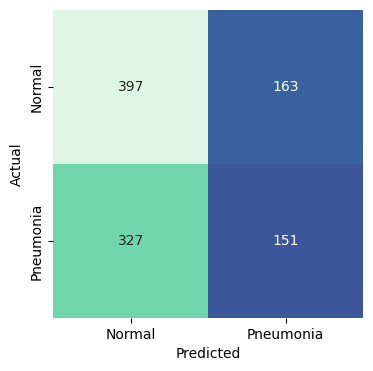

Accuracy:      64.56%
AUC:           62.81%
Precision:     48.09%
Recall:        31.59%


In [206]:
print_performance_results(model1)

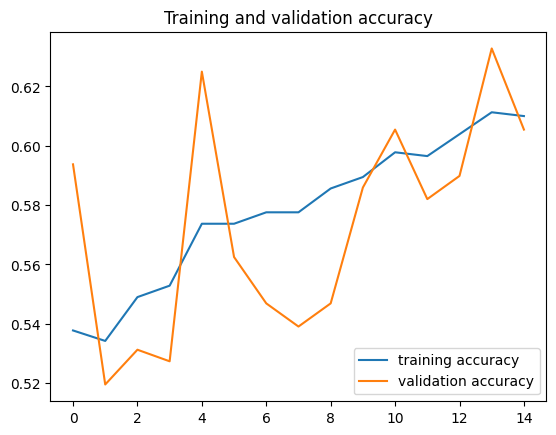

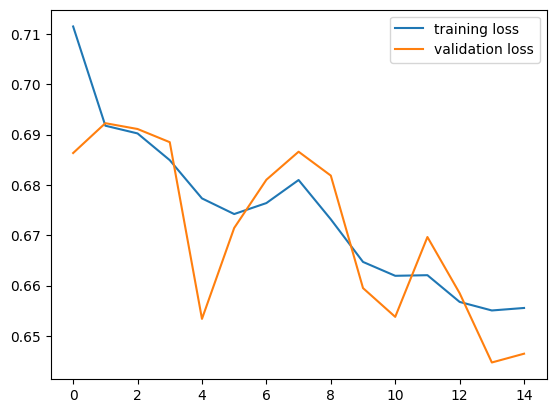

In [207]:
show_accuracy_charts(history1)

1/1 [==============================] - 0s 24ms/step
[[0.518805]]
1/1 [==============================] - 0s 17ms/step
[[0.51726764]]
1/1 [==============================] - 0s 31ms/step
[[0.5497466]]
1/1 [==============================] - 0s 29ms/step
[[0.32746089]]
1/1 [==============================] - 0s 20ms/step
[[0.45604503]]
1/1 [==============================] - 0s 19ms/step
[[0.37717685]]
1/1 [==============================] - 0s 17ms/step
[[0.39422864]]
1/1 [==============================] - 0s 20ms/step
[[0.3567105]]
1/1 [==============================] - 0s 21ms/step
[[0.5203447]]
1/1 [==============================] - 0s 25ms/step
[[0.41713607]]
1/1 [==============================] - 0s 34ms/step
[[0.55409855]]
1/1 [==============================] - 0s 23ms/step
[[0.5466963]]


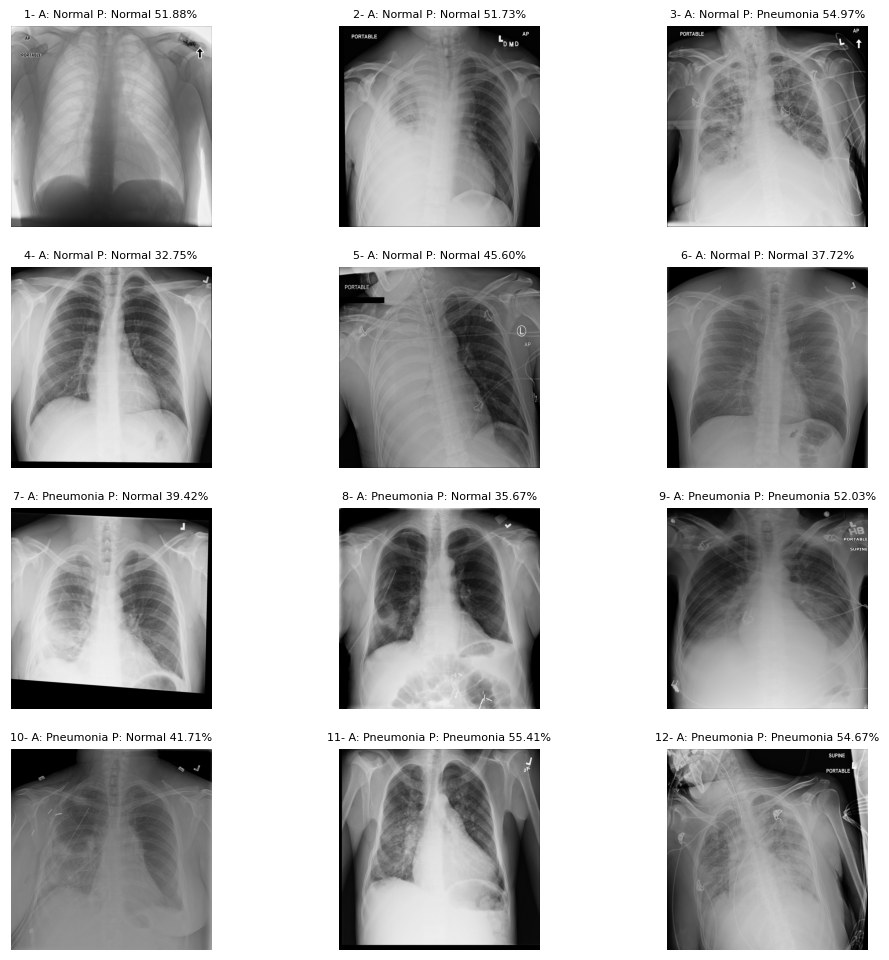

In [349]:
_CONFIDENCE_CRITERIA = .52
show_test_images_pred_img_panel(model1)

## Test Model2

In [290]:
#Test Model2
model2 = Sequential()
model2.add(Conv2D(filters = 32,kernel_size=(3,3),activation = 'relu' , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 64,kernel_size=(3,3),kernel_initializer="he_uniform",activation = 'relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 128,kernel_size=(3,3),kernel_initializer="he_uniform",activation = 'relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(units=128,activation='relu'))
model2.add(Dense(units=64,activation='relu'))
model2.add(Dropout(0.50))
model2.add(Dense(units = 1 , activation = 'sigmoid'))

In [291]:
optimizer= Adam()
model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 30, 30, 128)     

In [292]:
model_path2 = os.path.join(saved_model_folder_path,"best_model2.h5")
print(model_path2)
early_stop2 = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1,mode='auto')
checkpoint2 = ModelCheckpoint(model_path2,monitor='val_accuracy',save_best_only=True, mode='auto',verbose=1)
reduce_lr2 = ReduceLROnPlateau(monitor='accuracy',factor=0.1,patience=3,min_lr=0.00001,model='auto')
callbacks2 = [early_stop2,checkpoint2,reduce_lr2]

models_bkp/best_model2.h5


In [293]:
%%time
history2 = model2.fit_generator(generator=train_generator,epochs=50,validation_data=val_generator,validation_steps=16,workers=15,callbacks=callbacks2)

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 0.7188 - accuracy: 0.5318
Epoch 1: val_accuracy improved from -inf to 0.52344, saving model to models_bkp\best_model2.h5
195/195 [==============================] - 15s 69ms/step - loss: 0.7186 - accuracy: 0.5323 - val_loss: 0.6911 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.6916 - accuracy: 0.5344
Epoch 2: val_accuracy improved from 0.52344 to 0.54297, saving model to models_bkp\best_model2.h5
195/195 [==============================] - 14s 67ms/step - loss: 0.6916 - accuracy: 0.5342 - val_loss: 0.6884 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.5389
Epoch 3: val_accuracy did not improve from 0.54297
195/195 [==============================] - 14s 66ms/step - loss: 0.6908 - accuracy: 0.5387 - val_loss: 0.6931 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 4/50
194/195 [==========

In [272]:
model2 = load_model(model_path2)

### Result for the above model2


Classes:  {'normal': 0, 'pneumonia': 1}



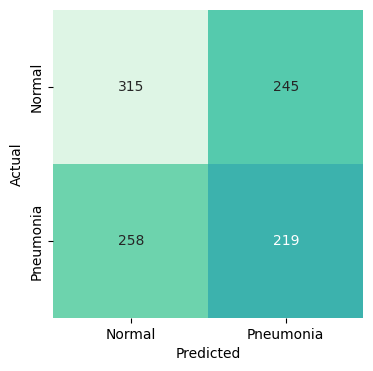

Accuracy:      62.61%
AUC:           66.44%
Precision:     47.20%
Recall:        45.91%


In [111]:
print_performance_results(model2)

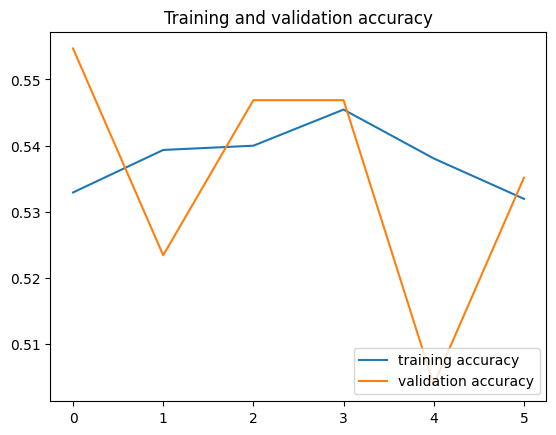

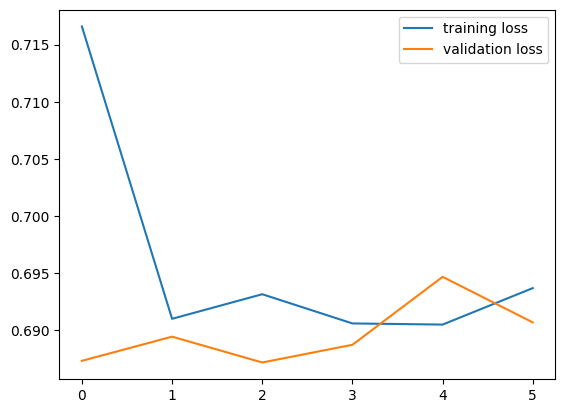

In [273]:
show_accuracy_charts(history2)

1/1 [==============================] - 0s 303ms/step
[[0.43902734]]
1/1 [==============================] - 0s 16ms/step
[[0.4632777]]
1/1 [==============================] - 0s 16ms/step
[[0.45219988]]
1/1 [==============================] - 0s 31ms/step
[[0.43675944]]
1/1 [==============================] - 0s 16ms/step
[[0.44630206]]
1/1 [==============================] - 0s 15ms/step
[[0.43865]]
1/1 [==============================] - 0s 16ms/step
[[0.45661345]]
1/1 [==============================] - 0s 16ms/step
[[0.44729123]]
1/1 [==============================] - 0s 19ms/step
[[0.4572494]]
1/1 [==============================] - 0s 19ms/step
[[0.4433138]]
1/1 [==============================] - 0s 16ms/step
[[0.4882266]]
1/1 [==============================] - 0s 19ms/step
[[0.46829396]]


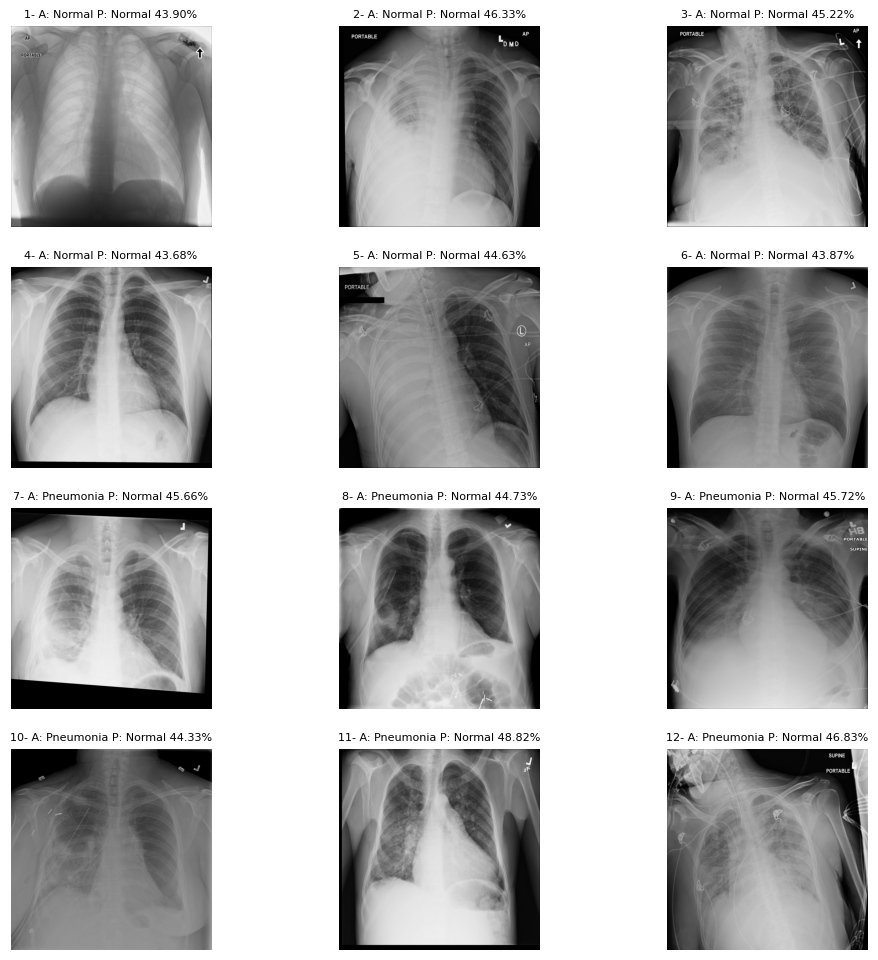

In [350]:
_CONFIDENCE_CRITERIA = .52
show_test_images_pred_img_panel(model2)

### Using MobileNetV2 
#### MobileNet was trained to classify images with 1000 class of images and at the end it have dense layer with 1000 nodes or activation layers and we want to take it off 
"include_top" is kept to False as we do not want to include dense layers with 1000 nodes and we want to train our model on the top of this pretrained model and should not include 1000 classes to classify in our model
"pooling" we have set as "avg" so that allow us to have one vector output

In [351]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
    include_top=False,
    weights="imagenet",
    pooling='avg')
mobilenet.trainable = False #Keeps the weights being trained

In [352]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
pretrained_model = mobilenet(inputs,training=False)
dense = tf.keras.layers.Dense(1024,activation='relu')(pretrained_model) 
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(dense)
model3 = tf.keras.Model(inputs,outputs)
print(model3.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_19 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_20 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [353]:
model_path3 = os.path.join(saved_model_folder_path,"best_model3.h5")
print(model_path3)
early_stop3 = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1,mode='auto')
checkpoint3 = ModelCheckpoint(model_path3,monitor='val_accuracy',save_best_only=True, mode='auto',verbose=1)
reduce_lr3 = ReduceLROnPlateau(monitor='accuracy',factor=0.1,patience=3,min_lr=0.00001,model='auto')
callbacks3 = [early_stop3,checkpoint3,reduce_lr3]

models_bkp/best_model3.h5


In [355]:
EPOCHS=50
BATCH_SIZE=35
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
)
history3 = model3.fit(
    train_generator,
    validation_data=val_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks3
)

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.6563 - auc: 0.7034
Epoch 1: val_accuracy improved from -inf to 0.66089, saving model to models_bkp\best_model3.h5
195/195 [==============================] - 63s 306ms/step - loss: 0.6335 - accuracy: 0.6563 - auc: 0.7034 - val_loss: 0.6011 - val_accuracy: 0.6609 - val_auc: 0.7611 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.6627 - auc: 0.7266
Epoch 2: val_accuracy improved from 0.66089 to 0.68882, saving model to models_bkp\best_model3.h5
195/195 [==============================] - 58s 295ms/step - loss: 0.6106 - accuracy: 0.6627 - auc: 0.7266 - val_loss: 0.5834 - val_accuracy: 0.6888 - val_auc: 0.7711 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.6762 - auc: 0.7355
Epoch 3: val_accuracy did not improve from 0.68882
195/195 [==============================] - 57s 292ms/step - loss: 0.

### Results

In [356]:
model3 = load_model(model_path3)


Classes:  {'normal': 0, 'pneumonia': 1}



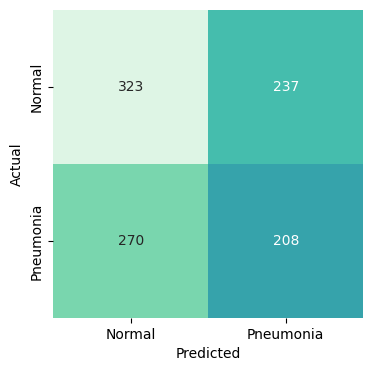

Accuracy:      58.01%
AUC:           69.46%
Precision:     46.74%
Recall:        43.51%


In [357]:
print_performance_results(model3)

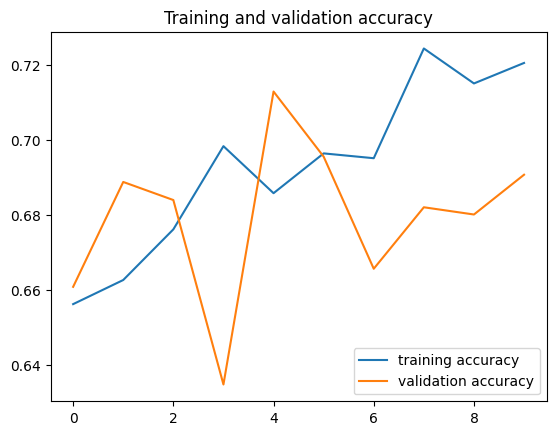

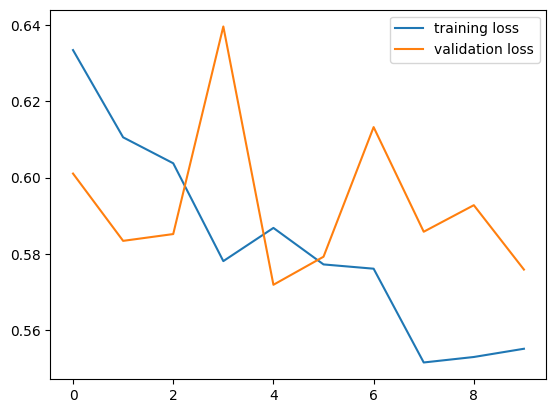

In [358]:
show_accuracy_charts(history3)

1/1 [==============================] - 1s 583ms/step
[[0.20442389]]
1/1 [==============================] - 0s 31ms/step
[[0.33535773]]
1/1 [==============================] - 0s 31ms/step
[[0.6734893]]
1/1 [==============================] - 0s 22ms/step
[[0.18333726]]
1/1 [==============================] - 0s 20ms/step
[[0.48843879]]
1/1 [==============================] - 0s 16ms/step
[[0.10179777]]
1/1 [==============================] - 0s 34ms/step
[[0.311572]]
1/1 [==============================] - 0s 18ms/step
[[0.31551057]]
1/1 [==============================] - 0s 15ms/step
[[0.5656961]]
1/1 [==============================] - 0s 20ms/step
[[0.4989342]]
1/1 [==============================] - 0s 16ms/step
[[0.3715186]]
1/1 [==============================] - 0s 19ms/step
[[0.537735]]


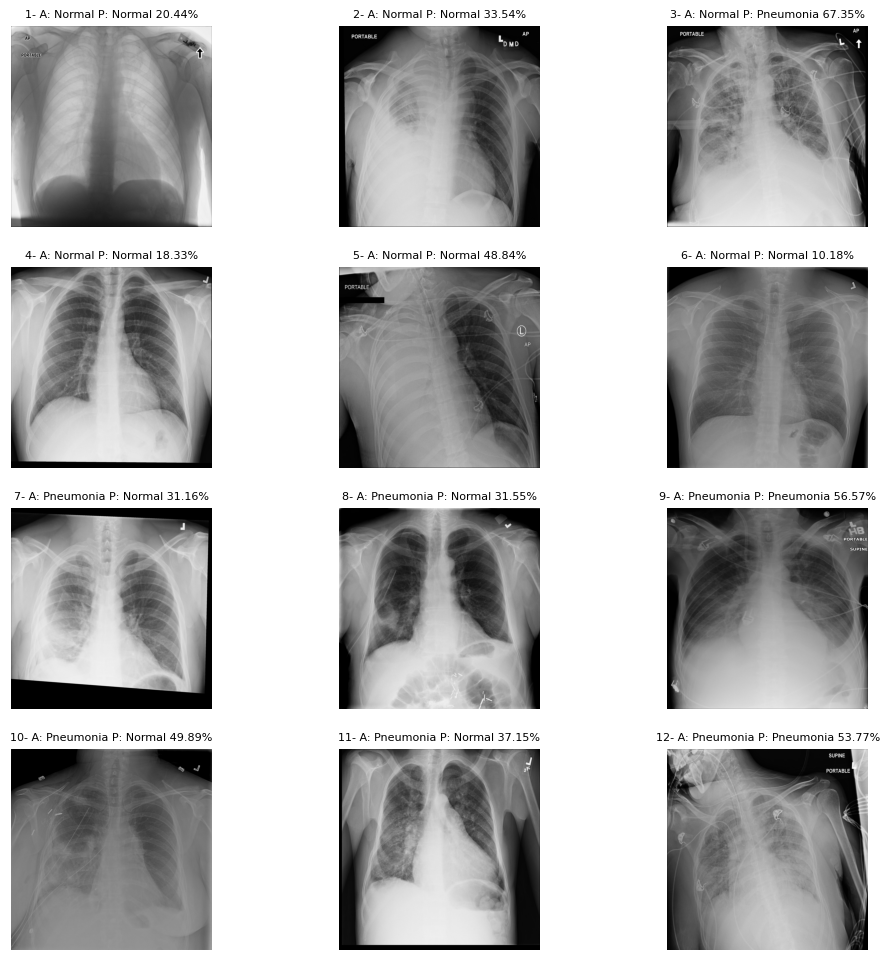

In [359]:
_CONFIDENCE_CRITERIA = .52
show_test_images_pred_img_panel(model3)

### Using VGG 16

In [360]:
#importing the VGG16 library as shown below and add preprocessing layer to the front of the VGG
#We will use imagenet weights. include_top ensure we dont get first and the last layer 
vgg = VGG16(input_shape=[IMG_HEIGHT,IMG_WIDTH]+[3],weights='imagenet',include_top=False)

In [361]:
#ensuring all the layer dont get trained
for layer in vgg.layers:
    layer.trainable = False

In [362]:
vgg16_x = Flatten()(vgg.output)
vgg16_pred = Dense(1,activation="sigmoid")(vgg16_x)
model4 = tf.keras.Model(inputs=vgg.input,outputs=vgg16_pred)

In [363]:
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [364]:
model_path4 = os.path.join(saved_model_folder_path,"best_model4.h5")
print(model_path4)
early_stop4 = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=10,verbose=1,mode='auto')
checkpoint4 = ModelCheckpoint(model_path4,monitor='val_accuracy',save_best_only=True, mode='auto',verbose=1)
reduce_lr4 = ReduceLROnPlateau(monitor='accuracy',factor=0.1,patience=3,min_lr=0.00001,model='auto')
callbacks4 = [early_stop4,checkpoint4,reduce_lr4]

models_bkp/best_model4.h5


In [366]:
model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
)
history4 = model4.fit_generator(
    train_generator,
    validation_data= val_generator,
    epochs=EPOCHS,
    callbacks=callbacks4
)

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.6354 - auc: 0.6763
Epoch 1: val_accuracy improved from -inf to 0.67726, saving model to models_bkp\best_model4.h5
195/195 [==============================] - 55s 280ms/step - loss: 0.7089 - accuracy: 0.6354 - auc: 0.6763 - val_loss: 0.6121 - val_accuracy: 0.6773 - val_auc: 0.7521 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6624 - auc: 0.7205
Epoch 2: val_accuracy did not improve from 0.67726
195/195 [==============================] - 57s 292ms/step - loss: 0.6689 - accuracy: 0.6624 - auc: 0.7205 - val_loss: 0.6603 - val_accuracy: 0.6657 - val_auc: 0.7763 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.6627 - auc: 0.7186
Epoch 3: val_accuracy improved from 0.67726 to 0.68304, saving model to models_bkp\best_model4.h5
195/195 [==============================] - 54s 278ms/step - loss: 0.

In [367]:
model4 = load_model(model_path4)

### Model4 Result


Classes:  {'normal': 0, 'pneumonia': 1}



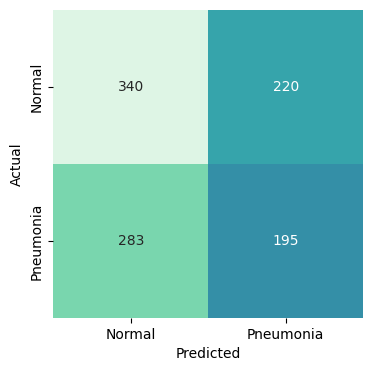

Accuracy:      61.52%
AUC:           71.00%
Precision:     46.99%
Recall:        40.79%


In [368]:
print_performance_results(model4)

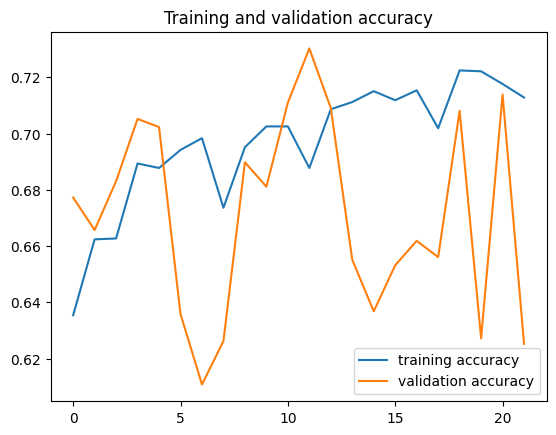

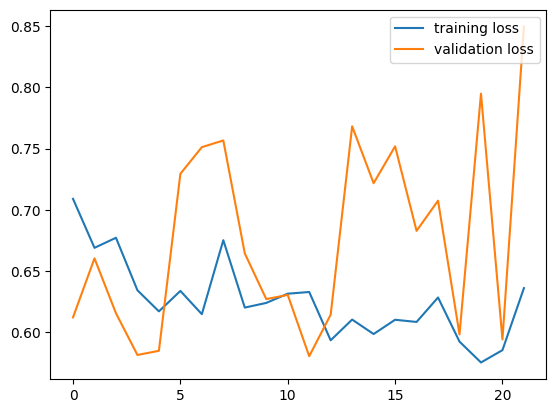

In [369]:
show_accuracy_charts(history4)

1/1 [==============================] - 1s 503ms/step
[[0.15321851]]
1/1 [==============================] - 0s 16ms/step
[[0.60776967]]
1/1 [==============================] - 0s 30ms/step
[[0.78351]]
1/1 [==============================] - 0s 32ms/step
[[0.05015829]]
1/1 [==============================] - 0s 31ms/step
[[0.36371034]]
1/1 [==============================] - 0s 32ms/step
[[0.06952075]]
1/1 [==============================] - 0s 32ms/step
[[0.448549]]
1/1 [==============================] - 0s 35ms/step
[[0.23729156]]
1/1 [==============================] - 0s 16ms/step
[[0.709824]]
1/1 [==============================] - 0s 16ms/step
[[0.38517132]]
1/1 [==============================] - 0s 19ms/step
[[0.38598502]]
1/1 [==============================] - 0s 32ms/step
[[0.7682301]]


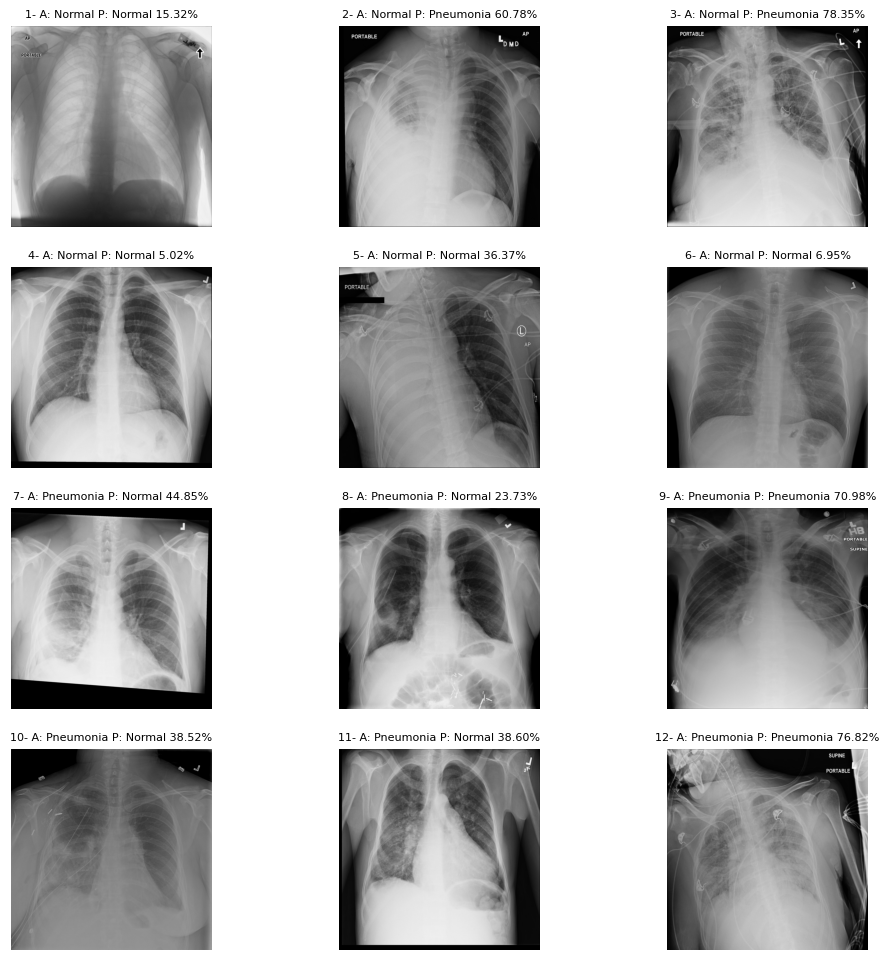

In [370]:
_CONFIDENCE_CRITERIA = .52
show_test_images_pred_img_panel(model4)

## Model 5

### Using VGG 16 _2nd config

In [538]:
IMG_WIDTH_VGG16 = 350
IMG_HEIGHT_VGG16 = 350
#importing the VGG16 library as shown below and add preprocessing layer to the front of the VGG
#We will use imagenet weights. include_top ensure we dont get first and the last layer 
vgg2 = VGG16(input_shape=[IMG_HEIGHT_VGG16,IMG_WIDTH_VGG16]+[3],weights='imagenet',include_top=False)
#ensuring all the layer dont get trained
for layer in vgg2.layers:
    layer.trainable = False

In [540]:
vgg16_x2 = Flatten()(vgg2.output)
vgg16_pred2 = Dense(1,activation="sigmoid")(vgg16_x2)
model5 = tf.keras.Model(inputs=vgg2.input,outputs=vgg16_pred2)

In [542]:
model5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 350, 350, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 350, 350, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 175, 175, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 175, 175, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 175, 175, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 87, 87, 128)       0   

In [543]:
model_path5 = os.path.join(saved_model_folder_path,"best_model5.h5")
print(model_path5)
early_stop5 = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=10,verbose=1,mode='auto')
checkpoint5 = ModelCheckpoint(model_path5,monitor='val_accuracy',save_best_only=True, mode='auto',verbose=1)
reduce_lr5 = ReduceLROnPlateau(monitor='accuracy',factor=0.1,patience=3,min_lr=0.00001,model='auto')
callbacks5 = [early_stop5,checkpoint5,reduce_lr5]

models_bkp/best_model5.h5


In [546]:
model5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
)
history5 = model5.fit_generator(
    train_generator_vgg16,
    validation_data= val_generator_vgg16,
    epochs=EPOCHS,
    callbacks=callbacks5
)

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.6065 - auc: 0.6394
Epoch 1: val_accuracy improved from -inf to 0.67919, saving model to models_bkp\best_model5.h5
195/195 [==============================] - 118s 593ms/step - loss: 0.8236 - accuracy: 0.6065 - auc: 0.6394 - val_loss: 0.5968 - val_accuracy: 0.6792 - val_auc: 0.7561 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.6640 - auc: 0.7237
Epoch 2: val_accuracy improved from 0.67919 to 0.68882, saving model to models_bkp\best_model5.h5
195/195 [==============================] - 101s 518ms/step - loss: 0.6807 - accuracy: 0.6640 - auc: 0.7237 - val_loss: 0.5995 - val_accuracy: 0.6888 - val_auc: 0.7617 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.6907 - auc: 0.7575
Epoch 3: val_accuracy did not improve from 0.68882
195/195 [==============================] - 102s 523ms/step - loss:

In [550]:
model5 = load_model(model_path5)

### Model5 Result


Classes:  {'normal': 0, 'pneumonia': 1}



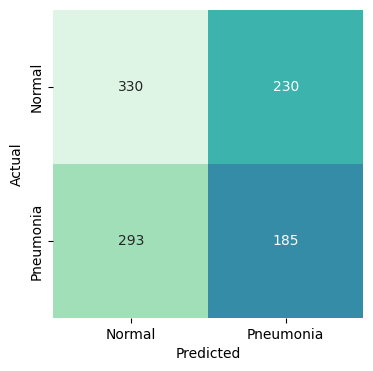

Accuracy:      61.52%
AUC:           71.00%
Precision:     44.58%
Recall:        38.70%


In [547]:
print_performance_results(model5)

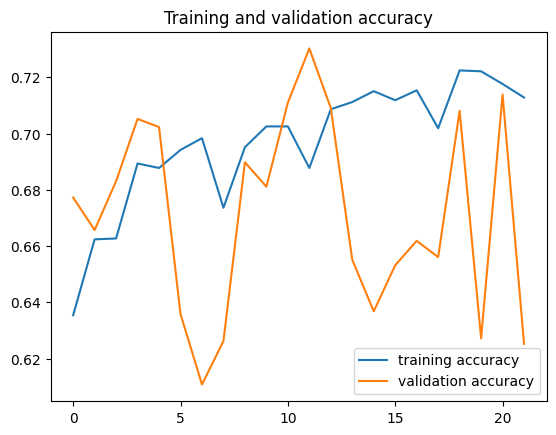

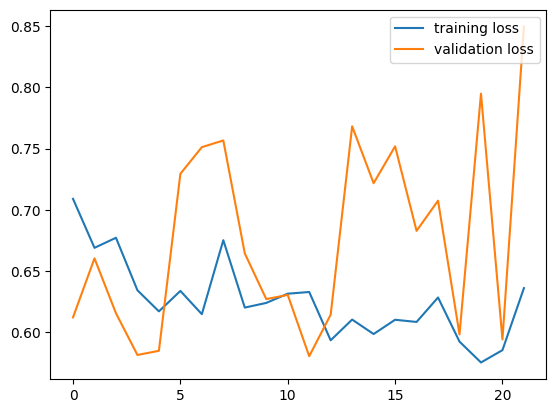

In [548]:
show_accuracy_charts(history5)

1/1 [==============================] - 0s 37ms/step
[[0.15321851]]
1/1 [==============================] - 0s 20ms/step
[[0.60776967]]
1/1 [==============================] - 0s 20ms/step
[[0.78351]]
1/1 [==============================] - 0s 30ms/step
[[0.05015829]]
1/1 [==============================] - 0s 23ms/step
[[0.36371034]]
1/1 [==============================] - 0s 20ms/step
[[0.06952075]]
1/1 [==============================] - 0s 18ms/step
[[0.448549]]
1/1 [==============================] - 0s 19ms/step
[[0.23729156]]
1/1 [==============================] - 0s 20ms/step
[[0.709824]]
1/1 [==============================] - 0s 15ms/step
[[0.38517132]]
1/1 [==============================] - 0s 12ms/step
[[0.38598502]]
1/1 [==============================] - 0s 16ms/step
[[0.7682301]]


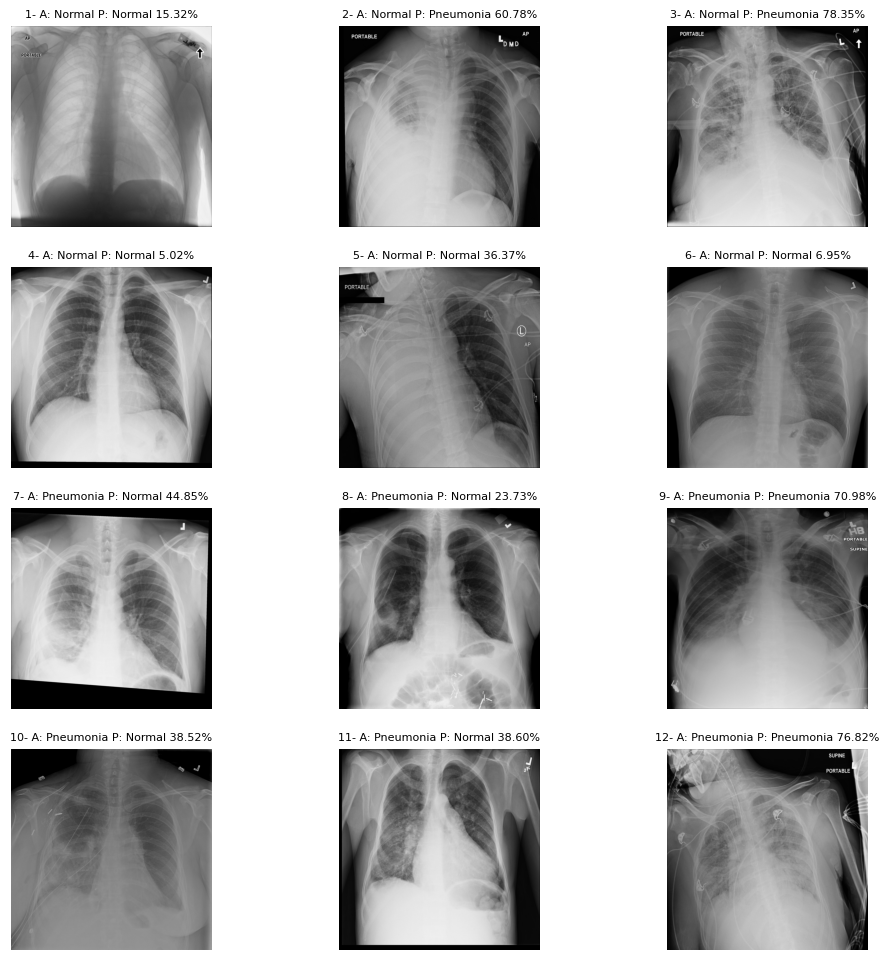

In [549]:
_CONFIDENCE_CRITERIA = .52
show_test_images_pred_img_panel(model5)

## Model 6 : ResNet50V2

In [562]:
base_model6 = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
    include_top=False)

base_model6.trainable = False

94668760/94668760 [==============================] - 21s 0us/step


In [574]:
def get_pretrained():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
    x = base_model6(inputs)
    # Head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    
    #Final Layer (Output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [575]:
keras.backend.clear_session()
model6 = get_pretrained()
model6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model6.summary()

ValueError: Input 0 of layer "max_pooling2d" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 2048)

In [559]:
model_path6 = os.path.join(saved_model_folder_path,"best_model6.h5")
print(model_path6)
early_stop6 = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1,mode='auto')
checkpoint6 = ModelCheckpoint(model_path6,monitor='val_accuracy',save_best_only=True, mode='auto',verbose=1)
reduce_lr6 = ReduceLROnPlateau(monitor='accuracy',factor=0.1,patience=5,min_lr=0.00001,model='auto')
callbacks6 = [early_stop6,checkpoint6,reduce_lr6]

models_bkp/best_model6.h5


In [561]:
history6 = model6.fit_generator(generator=train_generator,epochs=EPOCHS,validation_data=val_generator,validation_steps=16,workers=15,callbacks=callbacks6)

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.6505
Epoch 1: val_accuracy improved from -inf to 0.69531, saving model to models_bkp\best_model6.h5
195/195 [==============================] - 35s 146ms/step - loss: 0.6260 - accuracy: 0.6505 - val_loss: 0.5771 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.5938 - accuracy: 0.6833
Epoch 2: val_accuracy did not improve from 0.69531
195/195 [==============================] - 25s 126ms/step - loss: 0.5938 - accuracy: 0.6833 - val_loss: 0.6223 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.6926
Epoch 3: val_accuracy did not improve from 0.69531
195/195 [==============================] - 25s 125ms/step - loss: 0.5827 - accuracy: 0.6926 - val_loss: 0.5974 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.57

In [ ]:
print_performance_results(TL_Model)

### Image Annotations using YOLOV5

In [465]:
df_data_final.head()

level_0                             patientId  \
0     9198  1aea68e3-a8b7-4402-92a5-16a1f23c6d4a   
1    12539  ac056286-2e9a-43a7-8143-60082ef45a8b   
2     6532  6a0ece7e-c22b-4e33-9544-3e26b624ef82   
3    13470  ba6d52f7-d113-48aa-8adc-49f963ed8979   
4     7168  be00aef3-ebcf-4306-9960-a41b3c0cdafa   

                          class      x      y  width  height  Target  \
0                  Lung Opacity  676.0  262.0  202.0   453.0       1   
1                        Normal    NaN    NaN    NaN     NaN       0   
2  No Lung Opacity / Not Normal    NaN    NaN    NaN     NaN       0   
3                        Normal    NaN    NaN    NaN     NaN       0   
4                  Lung Opacity  621.0  234.0  188.0   271.0       1   

  Patient Sex Patient's Age View Position Image Size  
0           M            41            AP  1024x1024  
1           F            65            PA  1024x1024  
2           M            35            AP  1024x1024  
3           M            57            PA  1024x1024  
4           M            64            PA  1024x1024

In [87]:
#copying the relavant information in our sample data for using it in faster rcnn
df_fcnn = df_data_final.loc[:,["patientId","x","y","width","height","Target"]]

In [88]:
mapping_target_info = {
    0:'normal',
    1:'pneumonia'
}
df_fcnn["ClassName"] = [mapping_target_info[trgt] for trgt in  df_fcnn["Target"]]
df_fcnn["patientId"] = df_fcnn["patientId"] + ".jpg" 

In [89]:
df_fcnn.head()

patientId      x      y  width  height  \
0  48a44f52-7fb3-4384-a76b-f6170b03a357.jpg    NaN    NaN    NaN     NaN   
1  49b95513-daab-49bb-bc6e-c5254ab1bc07.jpg  599.0  202.0  216.0   537.0   
2  a985f470-12d9-48b0-bb1a-5bdffc657c47.jpg    NaN    NaN    NaN     NaN   
3  75ac9b0b-6f99-49f1-865c-3ccf54144b1a.jpg    NaN    NaN    NaN     NaN   
4  33c66fa9-6a08-4d0d-b309-88ce91a217c9.jpg  193.0  468.0  209.0   120.0   

   Target  ClassName  
0       0     normal  
1       1  pneumonia  
2       0     normal  
3       0     normal  
4       1  pneumonia

In [90]:
df_fcnn.rename(columns = {"patientId":"ImageID",'x':'XMin', 'y':'YMin','width':'XMax','height':'YMax'}, inplace = True)
df_fcnn['XMax'] = df_fcnn['XMin'] +  df_fcnn['XMax']
df_fcnn['YMax'] = df_fcnn['YMin'] +  df_fcnn['YMax']
df_fcnn['Xc'] = (df_fcnn['XMin'] +  df_fcnn['XMax'])/2
df_fcnn['Yc'] = (df_fcnn['YMin'] +  df_fcnn['YMax'])/2

# df_fcnn['XMin'] = df_fcnn['XMin']/1024
# df_fcnn['XMax'] = df_fcnn['XMax']/1024
# df_fcnn['YMin'] = df_fcnn['YMin']/1024
# df_fcnn['YMax'] = df_fcnn['YMax']/1024
print(df_fcnn.shape)
df_fcnn.head()

(6694, 9)


ImageID   XMin   YMin   XMax   YMax  \
0  48a44f52-7fb3-4384-a76b-f6170b03a357.jpg    NaN    NaN    NaN    NaN   
1  49b95513-daab-49bb-bc6e-c5254ab1bc07.jpg  599.0  202.0  815.0  739.0   
2  a985f470-12d9-48b0-bb1a-5bdffc657c47.jpg    NaN    NaN    NaN    NaN   
3  75ac9b0b-6f99-49f1-865c-3ccf54144b1a.jpg    NaN    NaN    NaN    NaN   
4  33c66fa9-6a08-4d0d-b309-88ce91a217c9.jpg  193.0  468.0  402.0  588.0   

   Target  ClassName     Xc     Yc  
0       0     normal    NaN    NaN  
1       1  pneumonia  707.0  470.5  
2       0     normal    NaN    NaN  
3       0     normal    NaN    NaN  
4       1  pneumonia  297.5  528.0

In [105]:
import torch

In [125]:
def create_YOLO_testtrainval_folder_structure():
    
    train_ = img_working_split_ + 'train/'
    test_ = img_working_split_ + 'test/'
    val_ = img_working_split_ + 'val/'
    
    _trNfiles = os.listdir(train_+'normal/')
    _trPfiles = os.listdir(train_+'pneumonia/')
    
    _tsNfiles = os.listdir(test_+'normal/')
    _tsPfiles = os.listdir(test_+'pneumonia/')
                           
    _vaNfiles = os.listdir(val_+'normal/')
    _vaPfiles = os.listdir(val_+'pneumonia/')
    
    
    """Train Annotations"""
    ii = 0
    
    x1,x2,y1,y2 = 0,0,0,0
    for _file in _trNfiles: #Train Normal
        _file_txt = _file.replace('.jpg','.txt')
        to_impath_ = os.path.join(img_working_yolo_images_train_dirname,_file) 
        dr_ = df_fcnn[df_fcnn["ImageID"] == _file]
        for idx, row in dr_.iterrows():
            cls_name = row["ClassName"]
            impath_ = train_+ cls_name+"/" + _file
        shutil.copy(impath_,to_impath_)
        ii += 1

    for _file in _trPfiles: #Train Pneumonia
        _file_txt = _file.replace('.jpg','.txt')
        to_impath_ = os.path.join(img_working_yolo_images_train_dirname,_file) 
        txtpath_ = os.path.join(img_working_yolo_labels_train_dirname,_file_txt)
        dr_ = df_fcnn[df_fcnn["ImageID"] == _file]
        for idx, row in dr_.iterrows():
            x1 = np.round(row["Xc"]/1024,5)
            y1 = np.round(row["Yc"]/1024,5)
            x2 = np.round(row["XMax"]/1024,5)
            y2 = np.round(row["YMax"]/1024,5)
            
            cls_name = row["ClassName"]
            impath_ = train_+ cls_name+"/" + _file
            with open(txtpath_,"w+") as f:
                f.write("1 " + str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + "\n") 
        shutil.copy(impath_,to_impath_)
        ii += 1
            
    print("Total Train text and images transfered to the respective YOLO directory : ", ii)
    
    
    """Test Annotations"""
    ii = 0
    x1,x2,y1,y2 = 0,0,0,0
    for _file in _tsNfiles: #Test Normal
        _file_txt = _file.replace('.jpg','.txt')
        dr_ = df_fcnn[df_fcnn["ImageID"] == _file]
        to_impath_ = os.path.join(img_working_yolo_images_test_dirname,_file) 
        for idx, row in dr_.iterrows():
            cls_name = row["ClassName"]
            impath_ = test_+ cls_name+"/" + _file
        shutil.copy(impath_,to_impath_)
        ii += 1

    for _file in _tsPfiles: #Test Pneumonia
        _file_txt = _file.replace('.jpg','.txt')
        dr_ = df_fcnn[df_fcnn["ImageID"] == _file]
        to_impath_ = os.path.join(img_working_yolo_images_test_dirname,_file) 
        txtpath_ = os.path.join(img_working_yolo_labels_test_dirname,_file_txt)
        for idx, row in dr_.iterrows():
            x1 = np.round(row["Xc"]/1024,5)
            y1 = np.round(row["Yc"]/1024,5)
            x2 = np.round(row["XMax"]/1024,5)
            y2 = np.round(row["YMax"]/1024,5)
            cls_name = row["ClassName"]
            impath_ = test_+ cls_name+"/" + _file
            with open(txtpath_,"w+") as f:
                f.write("1 " + str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + "\n") 
        shutil.copy(impath_,to_impath_)
        ii += 1
        
    print("Total Test text and images transfered to the respective YOLO directory : ", ii)
    
    """Validation Annotations"""
    ii = 0
    x1,x2,y1,y2 = 0,0,0,0
    for _file in _vaNfiles: #Normal
        _file_txt = _file.replace('.jpg','.txt')
        dr_ = df_fcnn[df_fcnn["ImageID"] == _file]
        to_impath_ = os.path.join(img_working_yolo_images_val_dirname,_file) 
        txtpath_ = os.path.join(img_working_yolo_labels_val_dirname,_file_txt)
        for idx, row in dr_.iterrows():
            cls_name = row["ClassName"]
            impath_ = val_+ cls_name+"/" + _file
        shutil.copy(impath_,to_impath_)
        ii += 1

    for _file in _vaPfiles: #Pneumonia
        _file_txt = _file.replace('.jpg','.txt')
        dr_ = df_fcnn[df_fcnn["ImageID"] == _file]
        to_impath_ = os.path.join(img_working_yolo_images_val_dirname,_file) 
        txtpath_ = os.path.join(img_working_yolo_labels_val_dirname,_file_txt)
        for idx, row in dr_.iterrows():
            x1 = np.round(row["Xc"]/1024,5)
            y1 = np.round(row["Yc"]/1024,5)
            x2 = np.round(row["XMax"]/1024,5)
            y2 = np.round(row["YMax"]/1024,5)
            cls_name = row["ClassName"]
            impath_ = val_+ cls_name+"/" + _file
            with open(txtpath_,"w+") as f:
                f.write("1 " + str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + "\n") 
        shutil.copy(impath_,to_impath_)
        ii += 1
        
    print("Total Val text and images transfered to the respective YOLO directory : ", ii)

In [126]:
#creating folder structure
create_image_directory_structure()
create_YOLO_testtrainval_folder_structure()

Total Train text and images transfered to the respective YOLO directory :  3131
Total Test text and images transfered to the respective YOLO directory :  1044
Total Val text and images transfered to the respective YOLO directory :  1044


In [1]:
#!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
#%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5  v7.0-63-gcdd804d Python-3.10.8 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


Setup complete  (16 CPUs, 15.8 GB RAM, 238.6/317.8 GB disk)


In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 1024 --batch 16 --epochs 30 --data yolo_images_data.yaml --weights yolov5s.pt --cache